In [ ]:
print("hello")

# Day-Ahead Electricity Price-Forecasting

In this Notebook, Ithe objective will lie in the 

## Chapter 0 - Import Packages &amp; Set a generic Working Directory 

In [2]:
import os # to set a generic working directory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb

import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

In [3]:
os.path.abspath("price-forecasting-joffrey.ipynb")

'/home/jovyan/work/my-price-forecast/price-forecasting-joffrey.ipynb'

In [4]:
cwd = os.getcwd()
print(cwd)

/home/jovyan/work/my-price-forecast


## Chapter 1 - Exploration and Cleaning

Here, I will describe and talk about the data more.

In [5]:
# Read the datasets
data_energy = pd.read_csv("data/df_fit_data_2019-01-01_2021-03-12_noDrop.csv") # Diese Zeitreihe geht bis zum 12. März 2021, bis 22:00 Uhr

Let's work on a copy, just to be safe:

In [6]:
df_energy = data_energy # let's work on a copy, just to be safe

Let's look at the data:

In [7]:
df_energy.head()

,Date-Time,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,...,RenGenF,RenGenIT,TransFromDach,TransToDach,TransToIT,SeasonAndProduct,tInfoDaySin,tInfoDayCos,tInfoYearSin,tInfoYearCos
0,2019-01-01 00:00:00+01:00,50.26,8600.0,43628.00,63450.0,11110.0,3736.0,57054.0,64931.0,7833.0,...,1698.0,3.0,2487.0,5900.0,2513.0,43.054583,-2.588190e-01,0.965926,0.001305,0.999999
1,2019-01-01 01:00:00+01:00,48.74,7732.0,41662.75,60800.0,10675.0,3599.0,57400.0,63555.0,6894.0,...,1680.0,3.0,2487.0,5900.0,2513.0,43.054583,-5.030095e-12,1.000000,0.002021,0.999998
2,2019-01-01 02:00:00+01:00,47.24,7563.0,40553.00,59950.0,10080.0,3599.0,57275.0,62104.0,6022.0,...,1675.0,2.0,2487.0,5900.0,2513.0,43.054583,2.588190e-01,0.965926,0.002738,0.999996
3,2019-01-01 03:00:00+01:00,36.29,7379.0,40261.25,56400.0,9793.0,3600.0,58024.0,59954.0,4649.0,...,1670.0,2.0,2487.0,5900.0,2513.0,43.054583,5.000000e-01,0.866025,0.003455,0.999994
4,2019-01-01 04:00:00+01:00,30.09,6996.0,40603.25,53550.0,9485.0,3600.0,59301.0,56724.0,4679.0,...,1664.0,2.0,2487.0,5900.0,2513.0,43.054583,7.071068e-01,0.707107,0.004172,0.999991


Let's drop the columns that account for seasonality, which Philipp created:

In [8]:
df_energy = df_energy.drop(['tInfoDaySin', 'tInfoDayCos', 'tInfoYearSin', 'tInfoYearCos'], axis=1)

In [9]:
df_energy.describe().round(2)

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,RenGenD,RenGenF,RenGenIT,TransFromDach,TransToDach,TransToIT,SeasonAndProduct
count,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00,19248.00
mean,39.17,7215.60,55176.95,53368.87,18271.63,4962.01,61060.26,59832.57,12100.57,44.73,19279.95,5503.55,772.19,2440.19,5732.69,2669.61,39.17
std,14.94,1046.77,9445.74,11862.06,4968.71,1757.93,14002.97,11320.02,3529.08,66.10,11305.25,3223.59,1136.28,1088.63,855.06,978.02,13.14
min,-59.61,4476.00,32722.00,29050.00,7344.00,1331.00,26362.00,29092.00,3850.00,0.00,794.00,416.00,0.00,-707.00,2171.00,0.00,-12.67
25%,30.49,6409.00,47441.12,44100.00,14315.75,3621.00,50295.50,51021.00,9299.00,0.00,10107.88,2891.75,6.00,1645.00,5400.00,2011.00,32.28
50%,38.58,7182.00,55191.62,51850.00,17508.50,4356.00,60875.00,59108.50,11793.00,11.00,17594.12,4933.00,27.00,2499.00,5900.00,2713.00,39.14
75%,47.60,7872.00,62956.60,61950.00,22791.25,6126.25,71490.50,68295.25,14826.00,66.00,27092.19,7428.00,1315.00,3165.00,6400.00,3504.00,46.86
max,126.70,10452.00,74996.00,87850.00,31617.00,10510.00,102390.00,88626.00,23865.00,336.00,63049.00,18380.00,4710.00,6000.00,6700.00,4585.00,82.83


In [10]:
df_energy.info() # check all data-types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19248 entries, 0 to 19247
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date-Time         19248 non-null  object 
 1   pricesCH          19248 non-null  float64
 2   LoadCH            19248 non-null  float64
 3   LoadD             19248 non-null  float64
 4   LoadF             19248 non-null  float64
 5   LoadIT            19248 non-null  float64
 6   GenCH             19248 non-null  float64
 7   GenD              19248 non-null  float64
 8   GenF              19248 non-null  float64
 9   GenIT             19248 non-null  float64
 10  RenGenCH          19248 non-null  float64
 11  RenGenD           19248 non-null  float64
 12  RenGenF           19248 non-null  float64
 13  RenGenIT          19248 non-null  float64
 14  TransFromDach     19248 non-null  float64
 15  TransToDach       19248 non-null  float64
 16  TransToIT         19248 non-null  float6

The `Date-Time`-column, which we want to be the index of the observations in a time-series, has not been parsed correctly and is recognized as an object. So we fix this:

In [11]:
# Convert time to datetime object and set it as index

df_energy['Date-Time'] = pd.to_datetime(df_energy['Date-Time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('Date-Time') # set the 'Date-Time'-Column as the index // row-label of our data-frame

In [12]:
df_energy.head()

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,RenGenD,RenGenF,RenGenIT,TransFromDach,TransToDach,TransToIT,SeasonAndProduct
Date-Time,,,,,,,,,,,,,,,,,
2018-12-31 23:00:00+00:00,50.26,8600.0,43628.00,63450.0,11110.0,3736.0,57054.0,64931.0,7833.0,2.0,23948.75,1698.0,3.0,2487.0,5900.0,2513.0,43.054583
2019-01-01 00:00:00+00:00,48.74,7732.0,41662.75,60800.0,10675.0,3599.0,57400.0,63555.0,6894.0,2.0,25668.75,1680.0,3.0,2487.0,5900.0,2513.0,43.054583
2019-01-01 01:00:00+00:00,47.24,7563.0,40553.00,59950.0,10080.0,3599.0,57275.0,62104.0,6022.0,2.0,27384.00,1675.0,2.0,2487.0,5900.0,2513.0,43.054583
2019-01-01 02:00:00+00:00,36.29,7379.0,40261.25,56400.0,9793.0,3600.0,58024.0,59954.0,4649.0,2.0,29010.25,1670.0,2.0,2487.0,5900.0,2513.0,43.054583
2019-01-01 03:00:00+00:00,30.09,6996.0,40603.25,53550.0,9485.0,3600.0,59301.0,56724.0,4679.0,2.0,30359.25,1664.0,2.0,2487.0,5900.0,2513.0,43.054583


In [13]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 0 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [14]:
# Display the number of non-missing values in each column.

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

pricesCH            19247
LoadCH              19248
LoadD               19248
LoadF               19248
LoadIT              19248
GenCH               19248
GenD                19248
GenF                19248
GenIT               19248
RenGenCH            14049
RenGenD             19248
RenGenF             19248
RenGenIT            18355
TransFromDach       19248
TransToDach         19248
TransToIT           19245
SeasonAndProduct    19248
dtype: int64


We see that there seem to be a lot of missing values in the `RenGenCH`-Column. However, the above "Trick" only works, if your columns don't contain values, that are '0'! This is because the number '0' - as a `boolean` - will be printed out to `False`, and hence, we will get the "wrong" number of missing values. 

*Verwende den oberen Code also nur, wenn du zuerst abgecheckt hast, dass du keine `0` in den einzlenen Spalten hast!*

In [15]:
(df_energy == 0).astype(int).sum(axis=0) # count the numbers of '0s' in each column

pricesCH               1
LoadCH                 0
LoadD                  0
LoadF                  0
LoadIT                 0
GenCH                  0
GenD                   0
GenF                   0
GenIT                  0
RenGenCH            5199
RenGenD                0
RenGenF                0
RenGenIT             893
TransFromDach          0
TransToDach            0
TransToIT              3
SeasonAndProduct       0
dtype: int64

Next, let's build a function that allows us to plot different types of time-series:

In [16]:
# Define a function to plot different types of time-series:

def plot_series(df=None, column=None, series=pd.Series([]), # the 'series'-Input will be useful, if we choose to plot the series in a monthly- or weekly-frequency, instead of hourly...
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-16-784a62db4182>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]), # the 'series'-Input will be useful, if we choose to plot the series in a monthly- or weekly-frequency, instead of hourly...


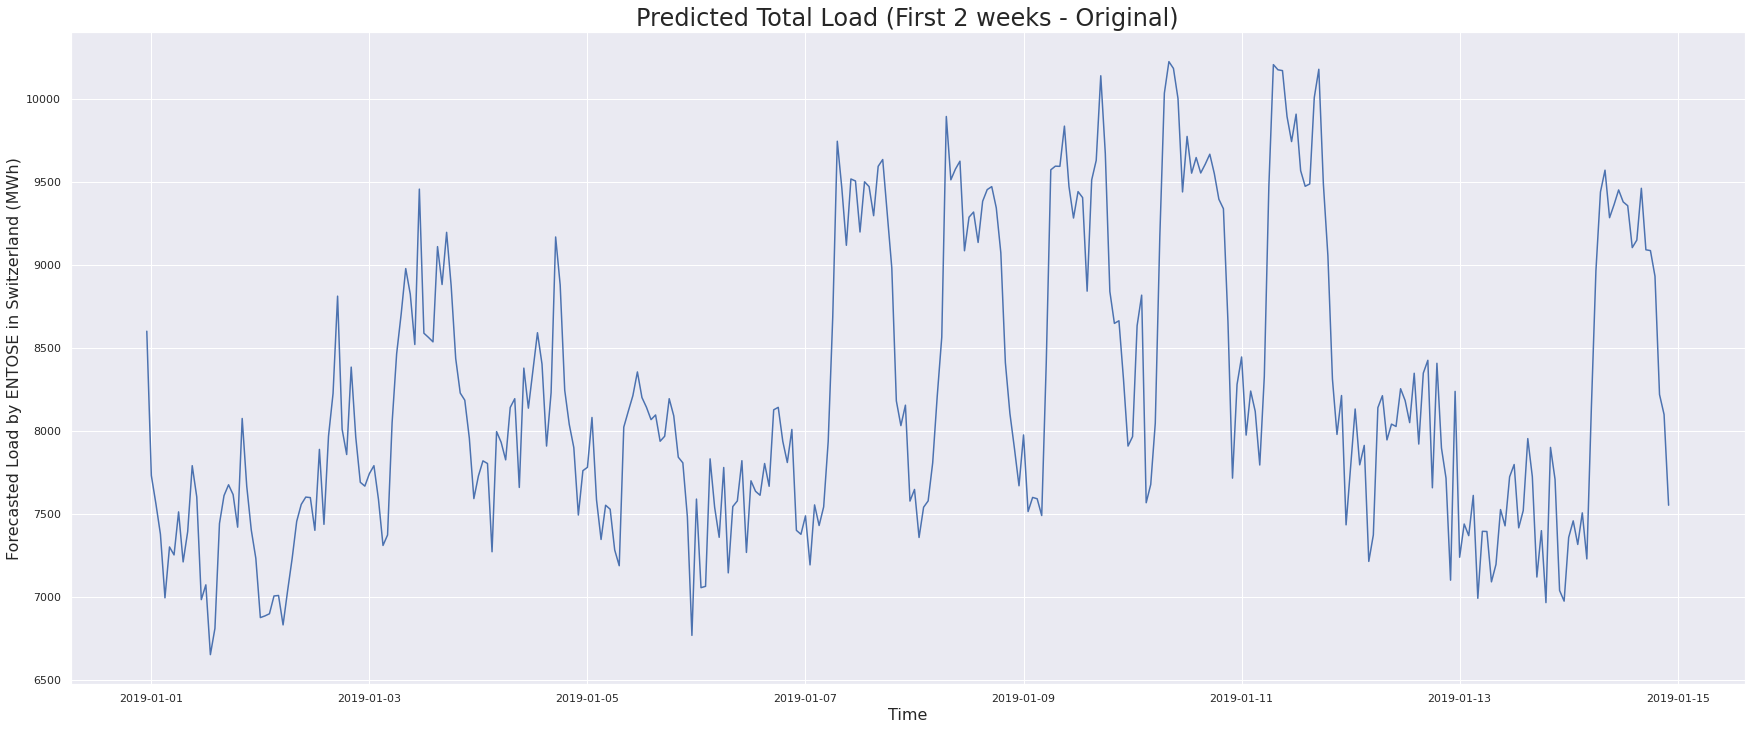

In [17]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='LoadCH', ylabel='Forecasted Load by ENTOSE in Switzerland (MWh)',
                 title='Predicted Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

We saw that RenGenCH-Column only had 5323 values. Let's check, if it is truly, because we have `0` in them:

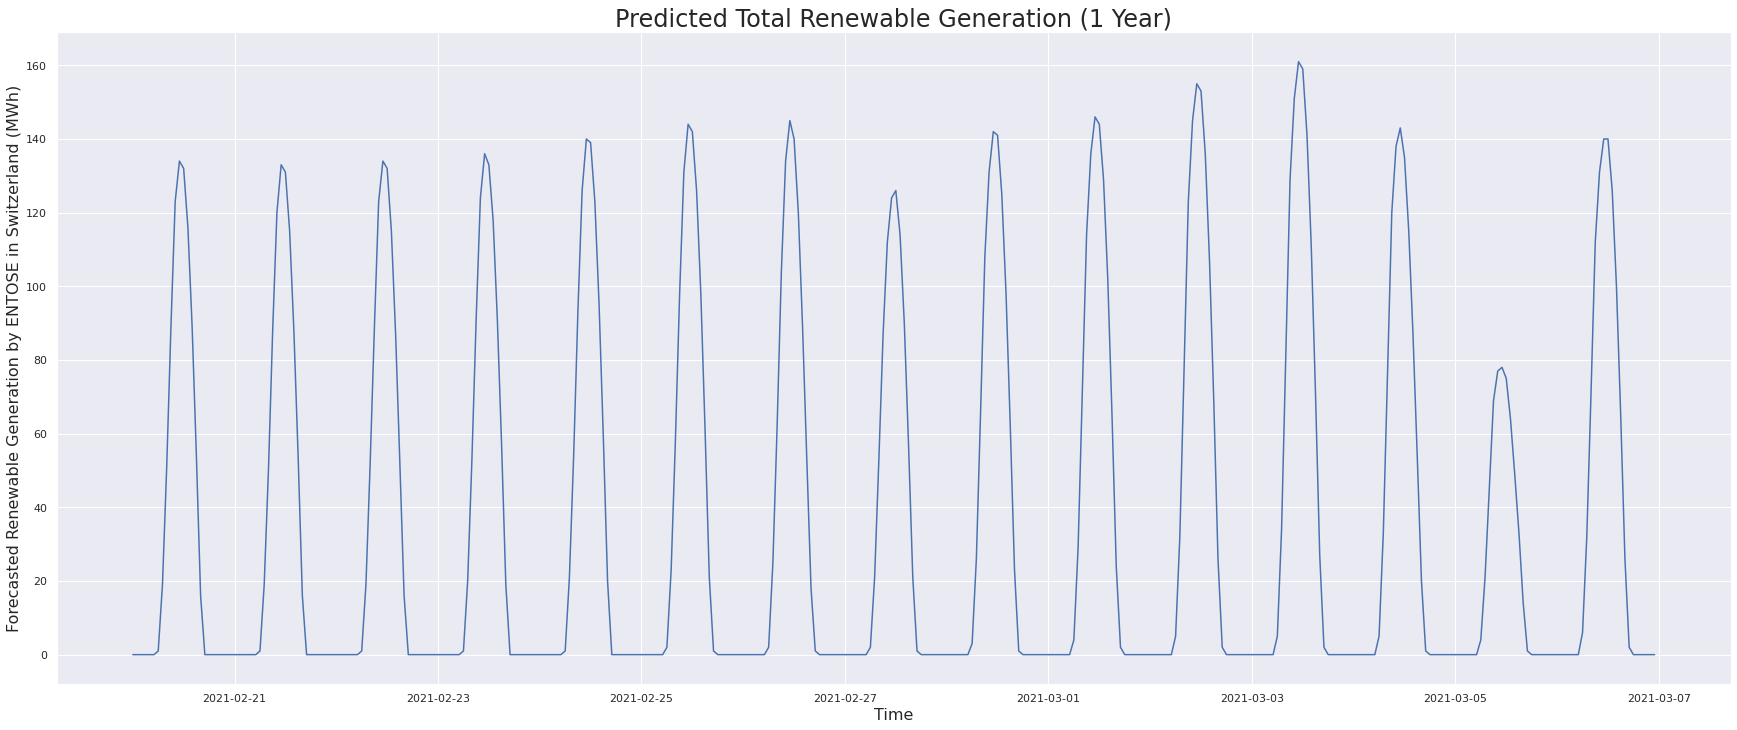

In [18]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='RenGenCH', ylabel='Forecasted Renewable Generation by ENTOSE in Switzerland (MWh)',
                 start= 1 + 24 * 781, end=1 + 24 * 796,
                 title='Predicted Total Renewable Generation (1 Year)')
plt.show()

Indeed, only by plotting the first 2 weeks, we already see that Switzerland produces `0` renewable energy during sequential days. This may look suspicious, but we need to keep in mind that this is (probably) because of load balancing, where the production will only be used during the peak hours during the week (for example, we see that, during the night, there is no production in the above graph).

In [19]:
n = df_energy.shape
print(n)

(19248, 17)


## Chapter 2 - Data Visualization

Next, let's explore the time series visually.

### <u>Make a rolling mean</u>:

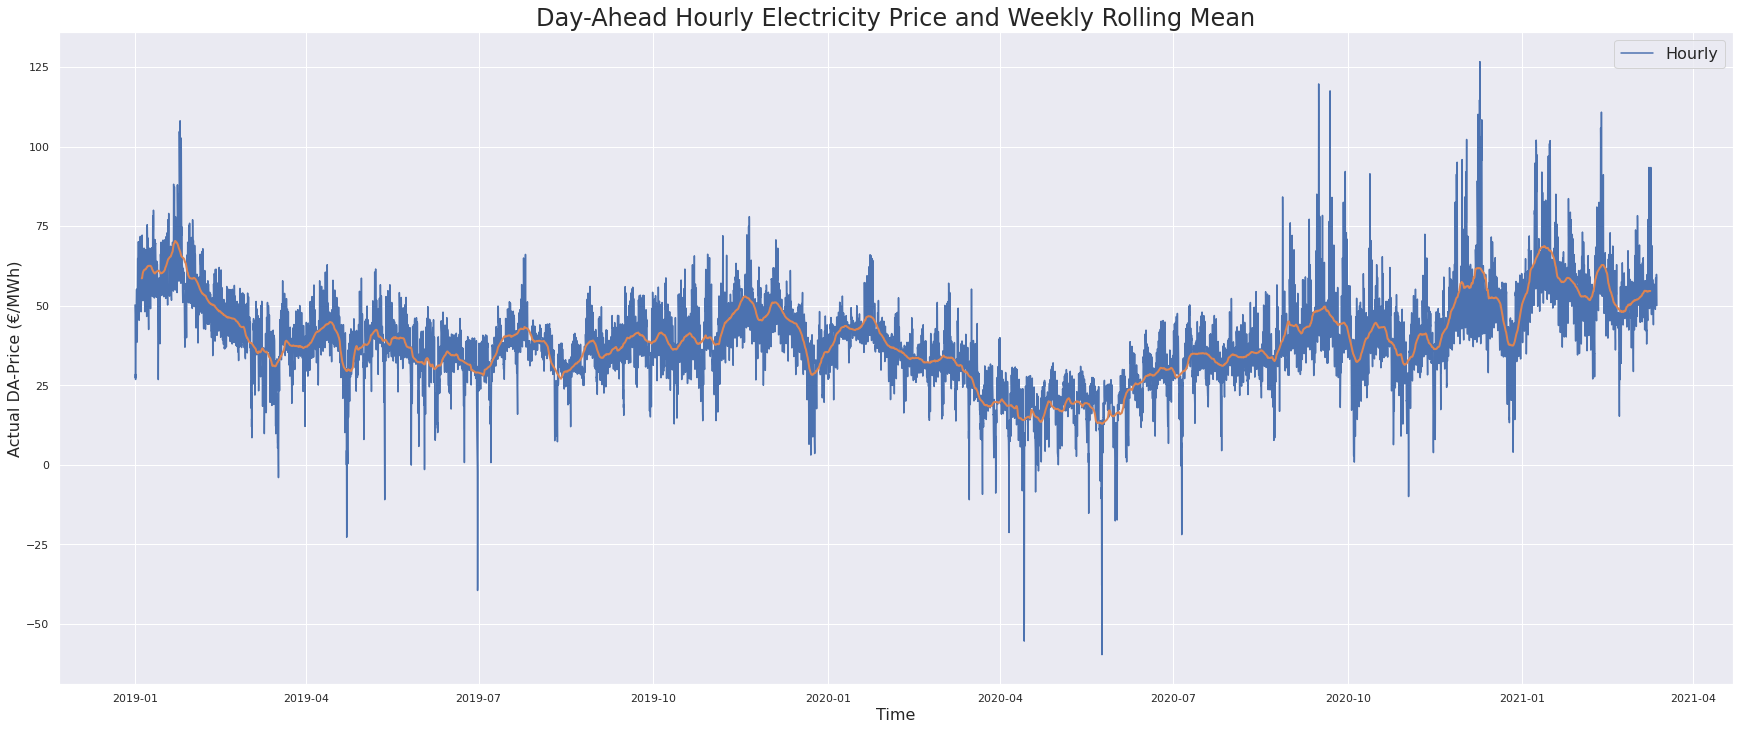

In [20]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_energy['pricesCH'].rolling(24*7, center=True).mean() # this is the rolling (weekly) mean
ax = plot_series(df_energy, 'pricesCH', label='Hourly', ylabel='Actual DA-Price (€/MWh)',
                 title='Day-Ahead Hourly Electricity Price and Weekly Rolling Mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean') # add the rolling mean to the hourly time-series
plt.show()

### <u>Check Seasonal-Patterns in the Time Series (monthly scale &amp; lagged series)</u>:

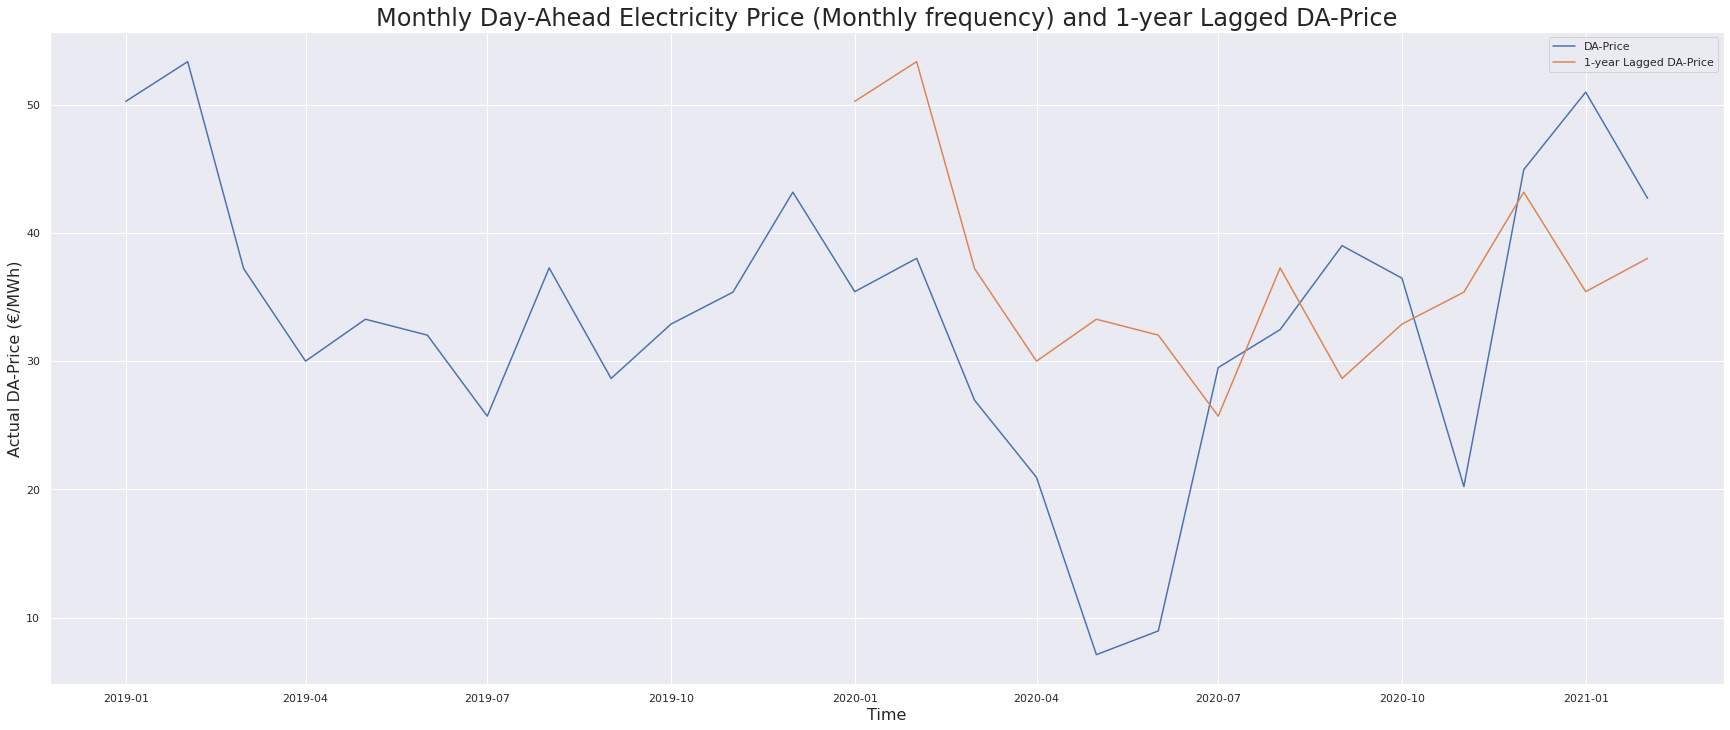

In [21]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

# Step 1: Aggregate the data
monthly_price = df_energy['pricesCH'].asfreq('M') # here, we aggregated the hourly DA-price over months -> save it as a series

# Step 2: Add the aggregated data to the plot
ax = plot_series(series=monthly_price, ylabel='Actual DA-Price (€/MWh)',
                 title='Monthly Day-Ahead Electricity Price (Monthly frequency) and 1-year Lagged DA-Price')

# Step 3: Take the year 2019 and shift it 12 periods (= 1 year) foreward 
shifted = df_energy['pricesCH'].asfreq('M').shift(12)

# Step 4: Add the shifted series to the plot
ax.plot(shifted, label='Hourly')
ax.legend(['DA-Price', '1-year Lagged DA-Price'])

# Step 5: final plot is ready
plt.show()

The figure above shows the (resampled) monthly frequency of the actual electricity price, along with its 1-year lagged monthly frequency. From this, we can see that there seem to be indeed **seasonal patterns at the monthly scale**, as certain "movements" &amp; "spikes" in the time-series take place in exactly the same months. However, we need to be careful, since we compare **"pre-covid" (= year 2019) VS. "during-covid" (lock-down) phases (during 2020)** in this graph, which require us to be careful. For example, take the **months in spring 2019 (normal economical conditions in Switzerland) VS. months in spring 2020 (first lockdown in Switzerland: from 16.03.2020 to 26.04.2020)**: we clearly see the lowest price reached at the end of April 2020, which indicates that the economic situation in Switzerland was extremely low. This is reflected in a very low (mothly) energy price.

Nevertheless, this means that it would be a good idea to create a new feature for the months.

### <u>Check Seasonal-Patterns at daily- / weekly-scale:

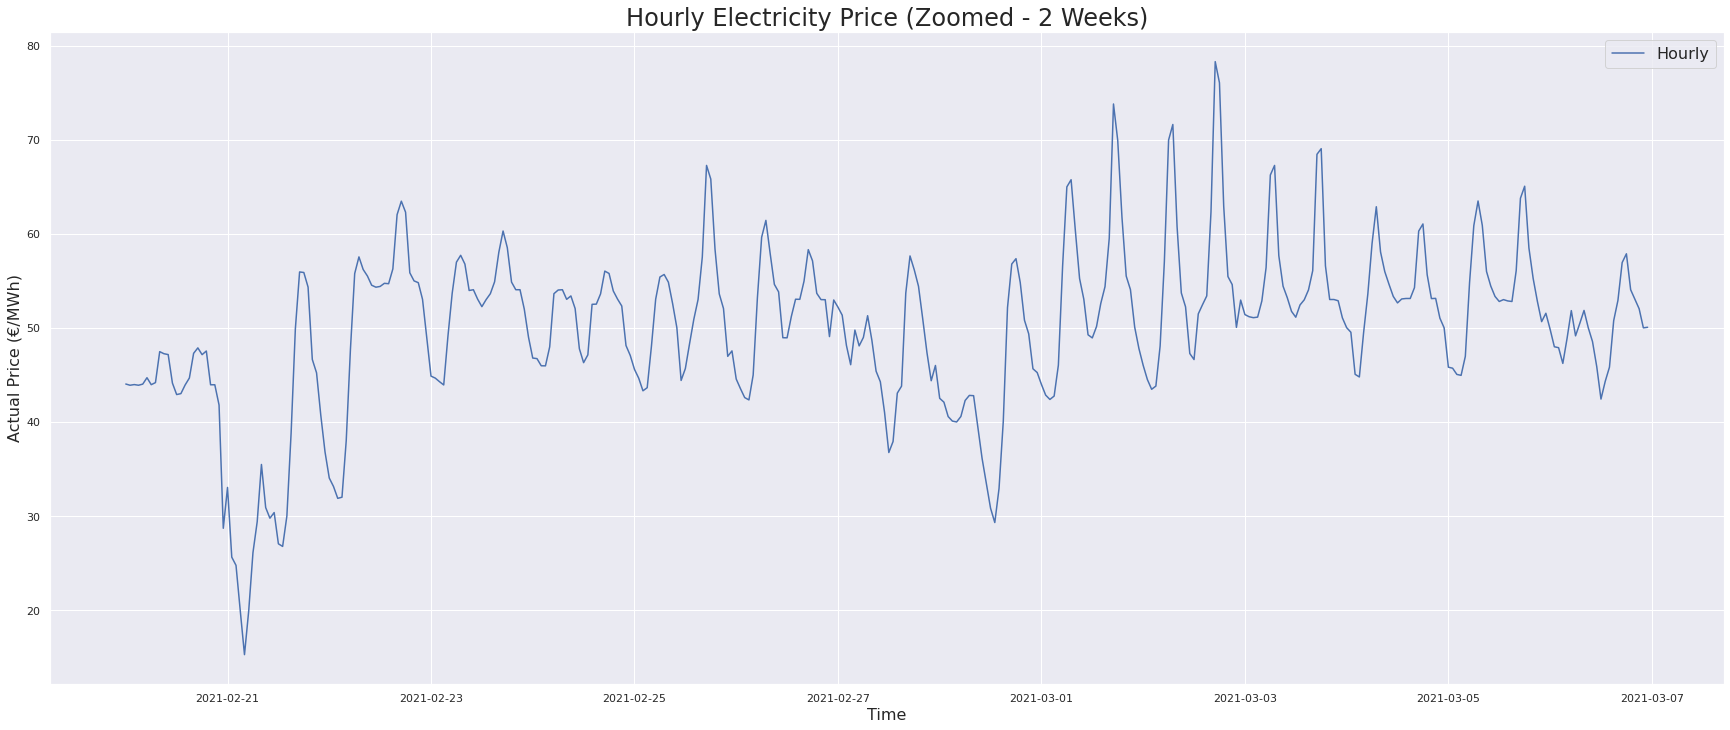

In [22]:
ax = plot_series(df_energy, 'pricesCH', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start= 1 + 24 * 781, end=1 + 24 * 796, # zoom in into 2 weeks, 750-765
                 title='Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

In the figure above, we have plotted the hourly day-ahad electricity price from 21/02/2021 (Sunday) at 00:00 up to 07/03/2021 (Sunday) at 23:00, i.e. two weeks of data. We can observe that there are many patterns and periodicities, such as:

- A periodicity from week to week, as the electricity price tends to be higher during business days and lower during weekends, especially during sundays (see sunday 21.02.2021 and sunday 28.02.2021, as well as saturday 06.03.2021).
- An intraday periodicity, as the price is higher during the day and lower during the night.

Later on, we will make sure that we will generate features which contain these kinds of information.

### <u>Check the hourly grow-rates of the day-ahead prices:

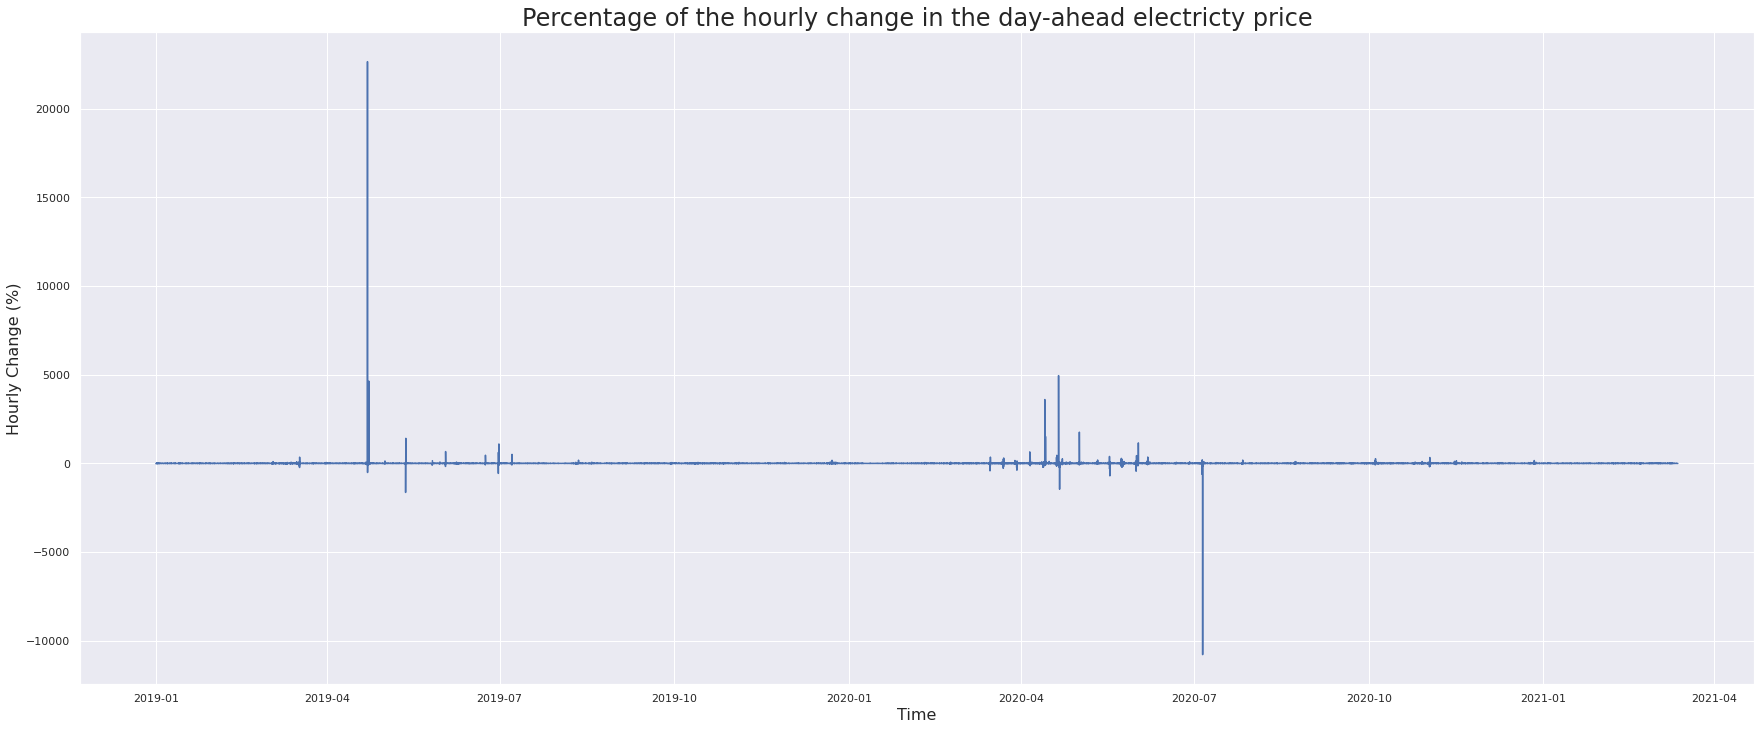

In [23]:
# Plot the percentage of the hourly change in the actual electricity price

change = (df_energy['pricesCH'].div(df_energy['pricesCH'].shift(1)) - 1)*100 # Divide the 'pricesCH'-colum with the lagged version of itself, substract 1, then multiply by 100, to get the growth-rate in %. Store it into a new variable called 'change'.
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the day-ahead electricty price')
plt.show()

Looking at this graph, there is clearly an outlier in the series. Let's check this:

In [24]:
change.describe().round(2)

count    19247.00
mean          inf
std           NaN
min     -10783.33
25%         -4.71
50%         -0.89
75%          3.56
max           inf
Name: pricesCH, dtype: float64

We have an **`infinite` mean** on a growth-rate, which means that **at least one DA-price in the series must be `0` EUR/MWh**, since a division by `0` will give an infinite growth-rate, which in turn will transform the mean to `inifinity`.

In [25]:
df_energy[df_energy['pricesCH'] == 0] # "Select" only the row where the column 'pricesCH' == 0 --> we see tht it is the 26th May that a day-ahead price of 0 was reached

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,RenGenD,RenGenF,RenGenIT,TransFromDach,TransToDach,TransToIT,SeasonAndProduct
Date-Time,,,,,,,,,,,,,,,,,
2019-05-26 13:00:00+00:00,0.0,6745.0,47141.25,39100.0,12785.0,3404.0,63780.0,48003.0,9470.0,184.0,35132.0,7772.0,2012.0,4133.0,5850.0,503.0,23.41875


Let's split the dataset in order to get a better picture:

In [26]:
change2 = change.loc[:'2019-05-26 13:00:00+00:00'] # this will slice the dataset until just before the 'infinity'-growth rate
change2

Date-Time
2018-12-31 23:00:00+00:00           NaN
2019-01-01 00:00:00+00:00     -3.024274
2019-01-01 01:00:00+00:00     -3.077554
2019-01-01 02:00:00+00:00    -23.179509
2019-01-01 03:00:00+00:00    -17.084596
                                ...    
2019-05-26 09:00:00+00:00    -25.013565
2019-05-26 10:00:00+00:00    -33.646889
2019-05-26 11:00:00+00:00    -88.440567
2019-05-26 12:00:00+00:00   -105.660377
2019-05-26 13:00:00+00:00   -100.000000
Name: pricesCH, Length: 3495, dtype: float64

Let's check again whether we have an infinite growth-rate:

In [27]:
change2.describe().round(2)

count     3494.00
mean         8.22
std        394.44
min      -1638.64
25%         -4.35
50%         -0.92
75%          3.53
max      22650.00
Name: pricesCH, dtype: float64

This time, we have no `inifinite` growth rate. However, there is still one extremely lare growth rate, which suggest that **at least one price is (very) close to `0` EUR/MWh**.

In [28]:
change2 = change2.to_frame()
change2.loc[change2.pricesCH == 22650.00, 'pricesCH']

Date-Time
2019-04-22 10:00:00+00:00    22650.0
Name: pricesCH, dtype: float64

In [29]:
df_energy[df_energy.index == "2019-04-22 09:00:00+00:00"] # "Select" just one hour before this crazy growth-rate --> we see tht it is the 22nd April, 9:00, that a day-ahead price of 0.02 CHF / MWh

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,RenGenD,RenGenF,RenGenIT,TransFromDach,TransToDach,TransToIT,SeasonAndProduct
Date-Time,,,,,,,,,,,,,,,,,
2019-04-22 09:00:00+00:00,0.02,6417.0,50129.25,43600.0,11467.0,3513.0,77798.0,45209.0,6289.0,245.0,43354.25,5586.0,2177.0,4750.0,5850.0,350.0,15.3275


In [30]:
change2 = change.loc[:'2019-04-22 09:00:00+00:00'] # this will slice the dataset until just before the extremely high growth rate
change2.describe().round(2)

count    2674.00
mean        0.30
std        13.32
min      -232.72
25%        -4.17
50%        -0.83
75%         3.19
max       351.39
Name: pricesCH, dtype: float64

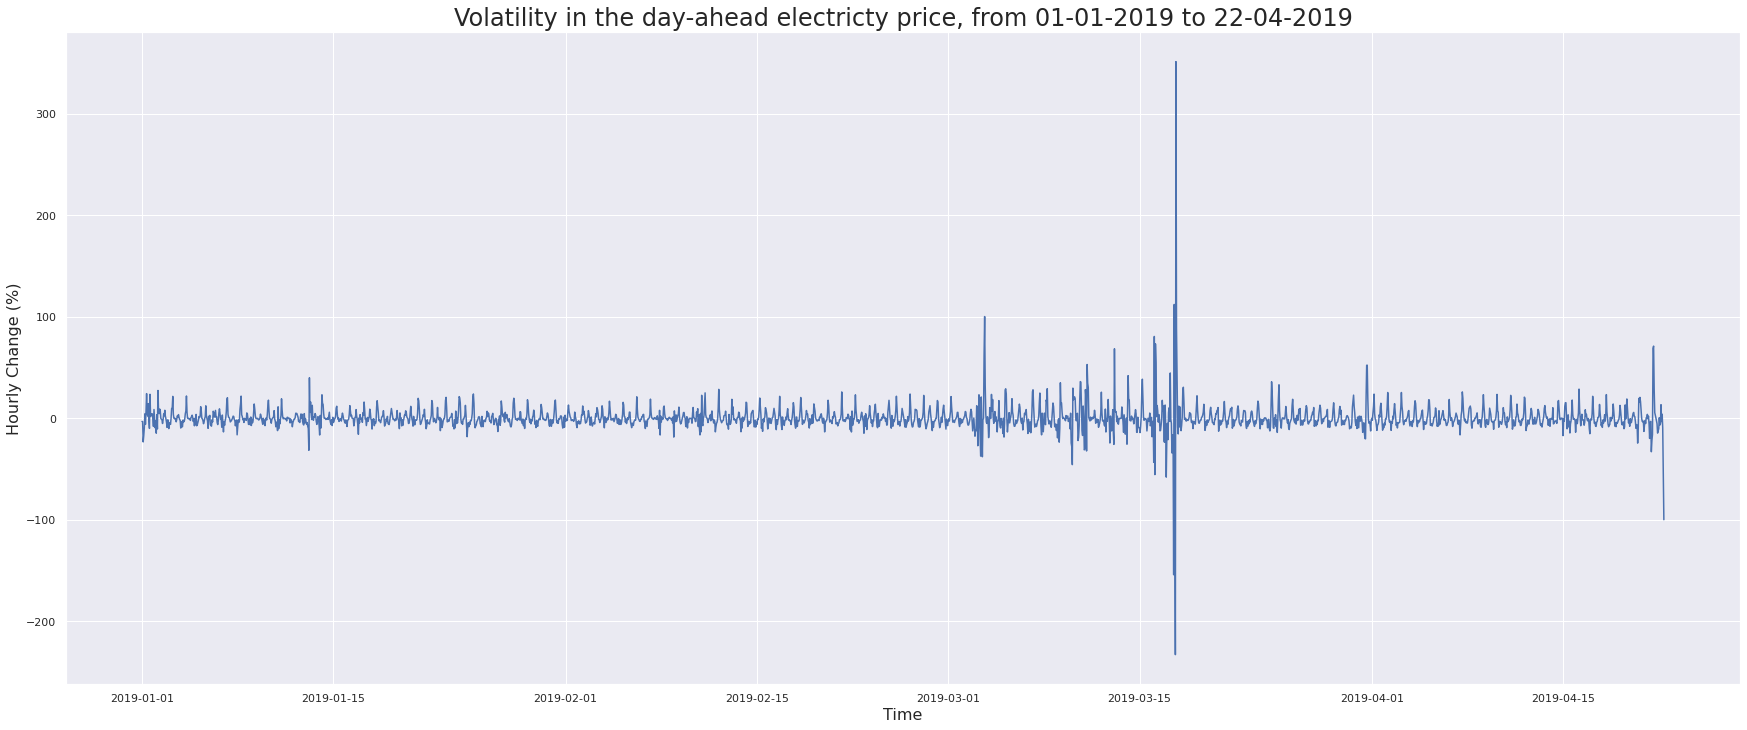

In [31]:
ax = plot_series(series=change2, ylabel='Hourly Change (%)', 
                 title='Volatility in the day-ahead electricty price, from 01-01-2019 to 22-04-2019')
plt.show()

Now, let's try to capture the energy-markets **pre-covid**-time, until around the beginning of the year 2020:

In [32]:
change3 = change.loc['2019-05-26 15:00:00+00:00':'2019-12-31 23:00:00+00:00'] # this will slice the dataset just after the 'infinity'-growth rate in May 2019 (start:'2019-05-26 15:00:00+00:00'; end: '2019-12-31 23:00:00+00:00')
change3 # Note: series starts at 15:00 Uhr!

Date-Time
2019-05-26 15:00:00+00:00    153.454545
2019-05-26 16:00:00+00:00     44.380679
2019-05-26 17:00:00+00:00     14.276250
2019-05-26 18:00:00+00:00      7.275362
2019-05-26 19:00:00+00:00     -3.809781
                                ...    
2019-12-31 19:00:00+00:00     -7.067634
2019-12-31 20:00:00+00:00     -7.403677
2019-12-31 21:00:00+00:00      0.353549
2019-12-31 22:00:00+00:00     -4.417344
2019-12-31 23:00:00+00:00      0.425291
Name: pricesCH, Length: 5265, dtype: float64

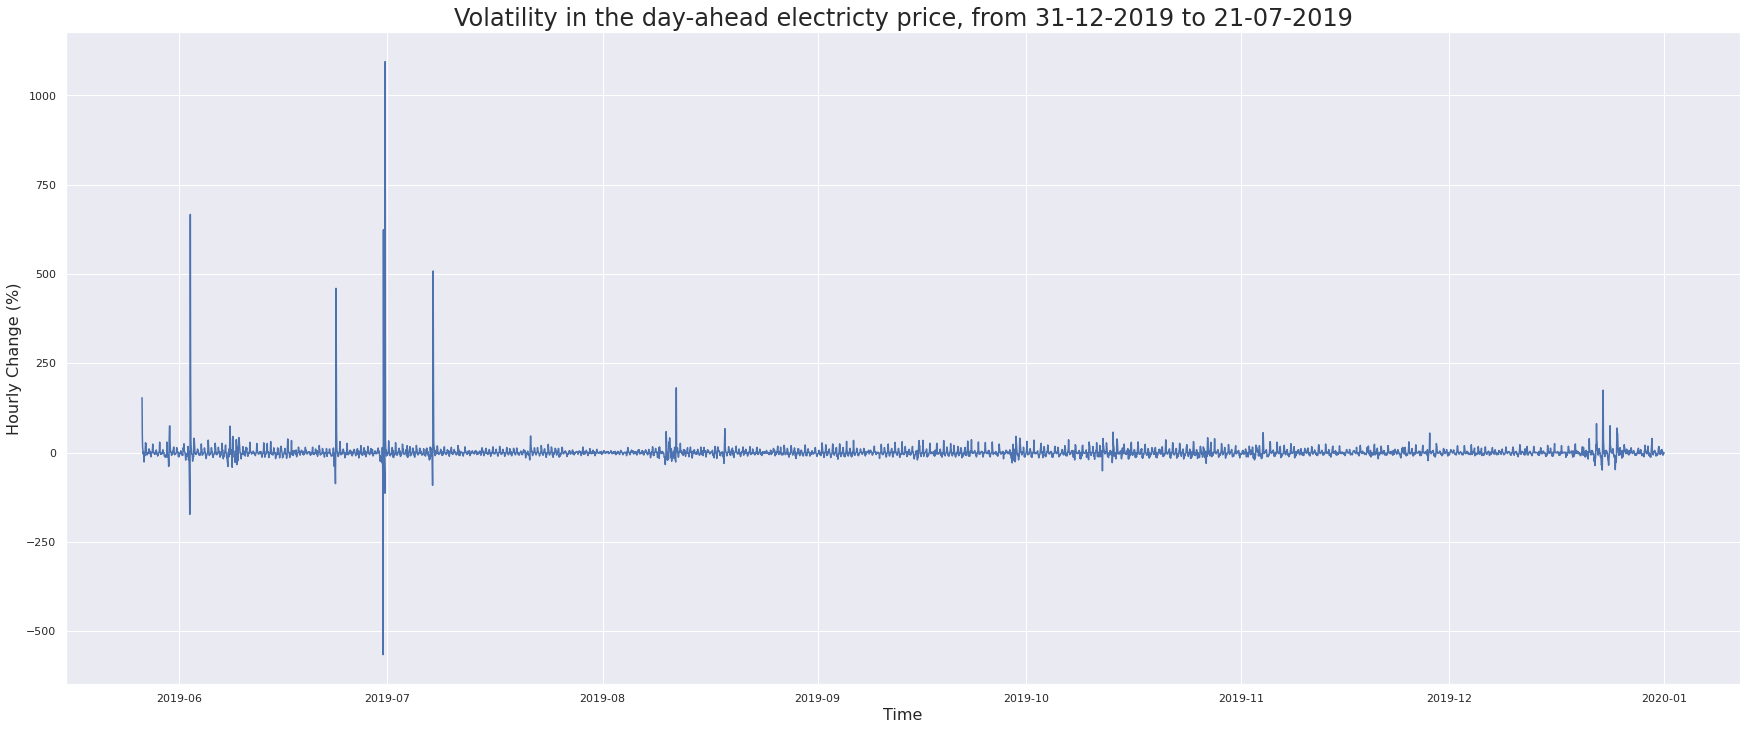

In [33]:
ax = plot_series(series=change3, ylabel='Hourly Change (%)', 
                 title='Volatility in the day-ahead electricty price, from 31-12-2019 to 21-07-2019')
plt.show()

Apart from the volatility-peaks during the end of June and July, we can also see that there seem to be **higher volatility right at the end of the year**, which hints at the fact that **holidays is an important factor** to consider.

Last but not least, let's capture **during covid period**.

In [34]:
change4 = change.loc['2020-01-01 00:00:00+00:00':] # this will slice the dataset just after the 'infinity'-growth rate in May 2019
change4 # Note: series starts at 15:00 Uhr!

Date-Time
2020-01-01 00:00:00+00:00    -3.896104
2020-01-01 01:00:00+00:00    -7.403055
2020-01-01 02:00:00+00:00   -10.247462
2020-01-01 03:00:00+00:00    -4.842701
2020-01-01 04:00:00+00:00     0.148588
                               ...    
2021-03-12 18:00:00+00:00    -1.369634
2021-03-12 19:00:00+00:00    -0.118544
2021-03-12 20:00:00+00:00    -4.120041
2021-03-12 21:00:00+00:00    -5.570292
2021-03-12 22:00:00+00:00    -6.254682
Name: pricesCH, Length: 10487, dtype: float64

Let's check, whether there are some extreme outliers first:

In [35]:
change4.describe().round(2)

count    10487.00
mean         0.74
std        127.62
min     -10783.33
25%         -5.10
50%         -1.01
75%          3.85
max       4950.00
Name: pricesCH, dtype: float64

Indeed, there is an extreme outlier (negative) growth rate of -10'783.33%. Furthermore, there is also one extreme positive growth rate, at +4950% (and another one at +3600%, as we will see). Let's check when those two (three, in fact) days happened:

In [36]:
change4_df = change4.to_frame()
change4_df.loc[change4_df.pricesCH < -10000, 'pricesCH']

Date-Time
2020-07-05 12:00:00+00:00   -10783.333333
Name: pricesCH, dtype: float64

In [37]:
change4_df = change4.to_frame()
change4_df.loc[change4_df.pricesCH > 3000, 'pricesCH']

Date-Time
2020-04-13 08:00:00+00:00    3600.0
2020-04-20 14:00:00+00:00    4950.0
Name: pricesCH, dtype: float64

In [38]:
change4 = change.loc['2020-01-01 00:00:00+00:00':'2020-04-13 07:00:00+00:00'] # this will slice the dataset just before the extremely positive growth rate in April 2020, at '2020-04-13 08:00:00+00:00'
change4 # Note: series ends at 11:00 Uhr!

Date-Time
2020-01-01 00:00:00+00:00     -3.896104
2020-01-01 01:00:00+00:00     -7.403055
2020-01-01 02:00:00+00:00    -10.247462
2020-01-01 03:00:00+00:00     -4.842701
2020-01-01 04:00:00+00:00      0.148588
                                ...    
2020-04-13 03:00:00+00:00     86.666667
2020-04-13 04:00:00+00:00     37.857143
2020-04-13 05:00:00+00:00    -81.865285
2020-04-13 06:00:00+00:00   -125.714286
2020-04-13 07:00:00+00:00    -66.666667
Name: pricesCH, Length: 2480, dtype: float64

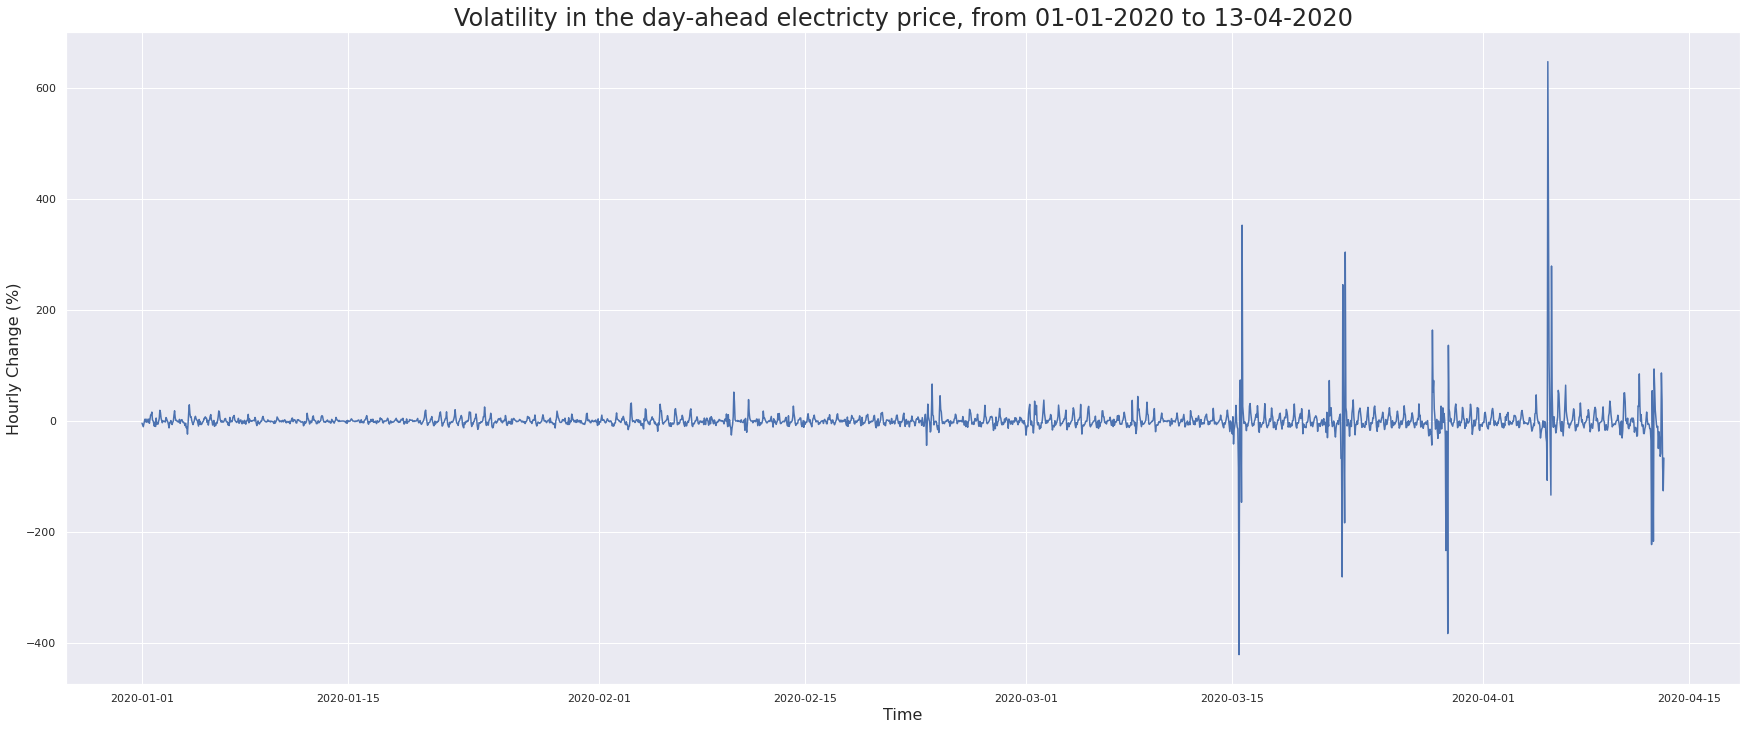

In [39]:
ax = plot_series(series=change4, ylabel='Hourly Change (%)', 
                 title='Volatility in the day-ahead electricty price, from 01-01-2020 to 13-04-2020')
plt.show()

In [40]:
change5 = change.loc['2020-04-13 00:00:00+00:00':'2020-04-20 23:00:00+00:00'] # this is the 'crazy week', where 2 extremely positive growth rate happened, mid-April 2020, starting at '2020-04-13 08:00:00+00:00' to '2020-04-20 14:00:00+00:00'
change5 # Note: series ends at 11:00 Uhr!

Date-Time
2020-04-13 00:00:00+00:00   -32.275862
2020-04-13 01:00:00+00:00   -63.543788
2020-04-13 02:00:00+00:00   -58.100559
2020-04-13 03:00:00+00:00    86.666667
2020-04-13 04:00:00+00:00    37.857143
                               ...    
2020-04-20 19:00:00+00:00   -13.564815
2020-04-20 20:00:00+00:00   -19.657204
2020-04-20 21:00:00+00:00   -12.066667
2020-04-20 22:00:00+00:00   -64.215315
2020-04-20 23:00:00+00:00    -9.110169
Name: pricesCH, Length: 192, dtype: float64

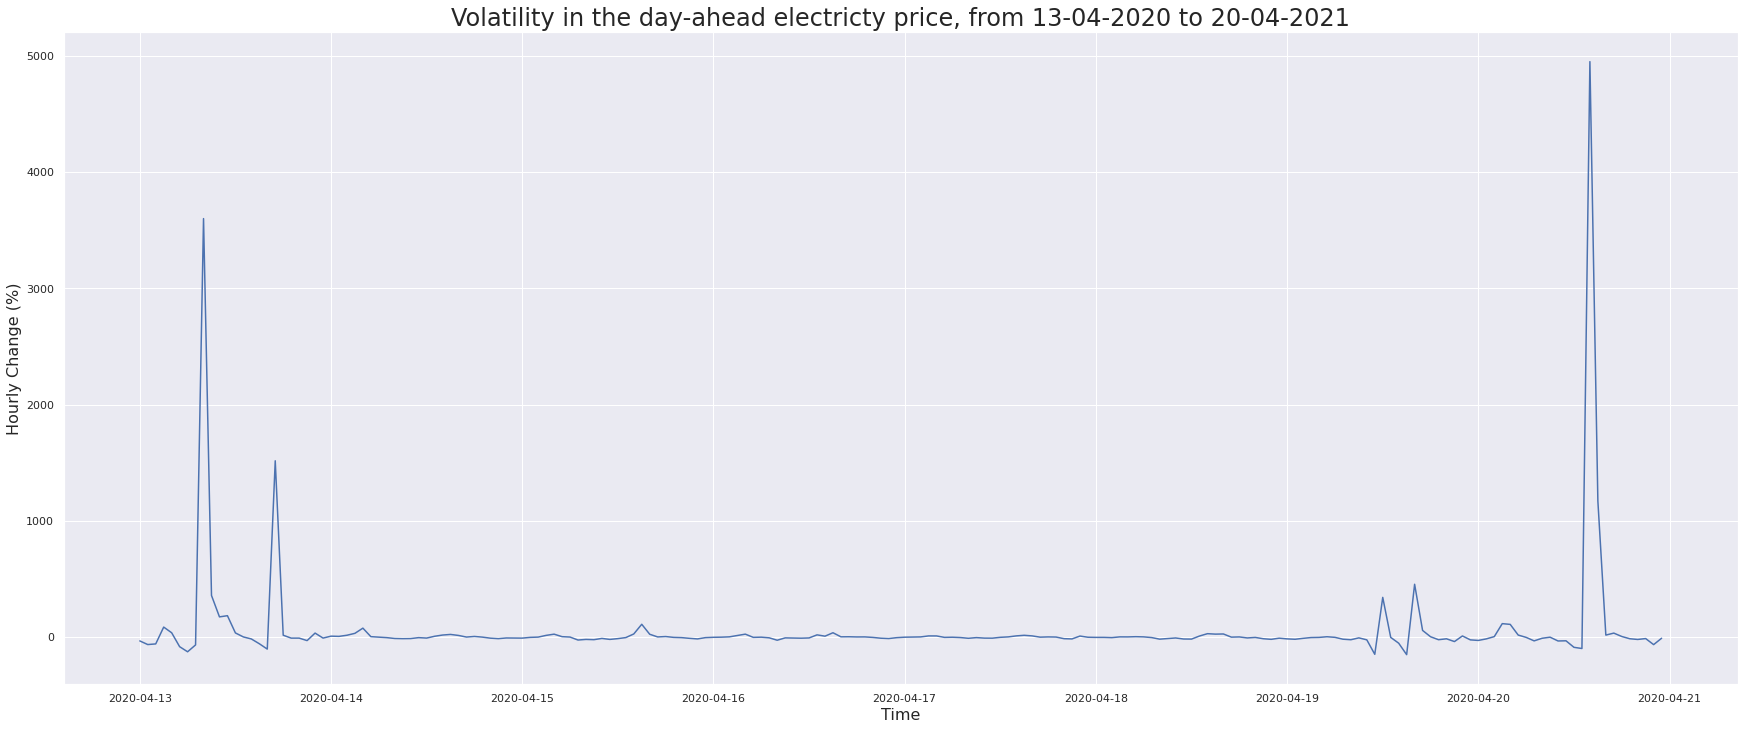

In [41]:
ax = plot_series(series=change5, ylabel='Hourly Change (%)', 
                 title='Volatility in the day-ahead electricty price, from 13-04-2020 to 20-04-2021')
plt.show()

In [42]:
change6 = change.loc['2020-04-21 00:00:00+00:00':'2020-07-05 11:00:00+00:00'] # Next, let's plot the next part the time series, just after the mid-April 2020 craziness, starting at '2020-04-21 00:00:00+00:00' just before the unbelievably negative growth-rate, that happened at '2020-07-05 12:00:00+00:00' 
change6 # Note: series ends at 11:00 Uhr!

Date-Time
2020-04-21 00:00:00+00:00     -70.163170
2020-04-21 01:00:00+00:00    -247.656250
2020-04-21 02:00:00+00:00     -67.724868
2020-04-21 03:00:00+00:00   -1457.377049
2020-04-21 04:00:00+00:00      65.217391
                                ...     
2020-07-05 07:00:00+00:00     198.918919
2020-07-05 08:00:00+00:00      -2.712477
2020-07-05 09:00:00+00:00      29.739777
2020-07-05 10:00:00+00:00     -50.716332
2020-07-05 11:00:00+00:00     -96.511628
Name: pricesCH, Length: 1812, dtype: float64

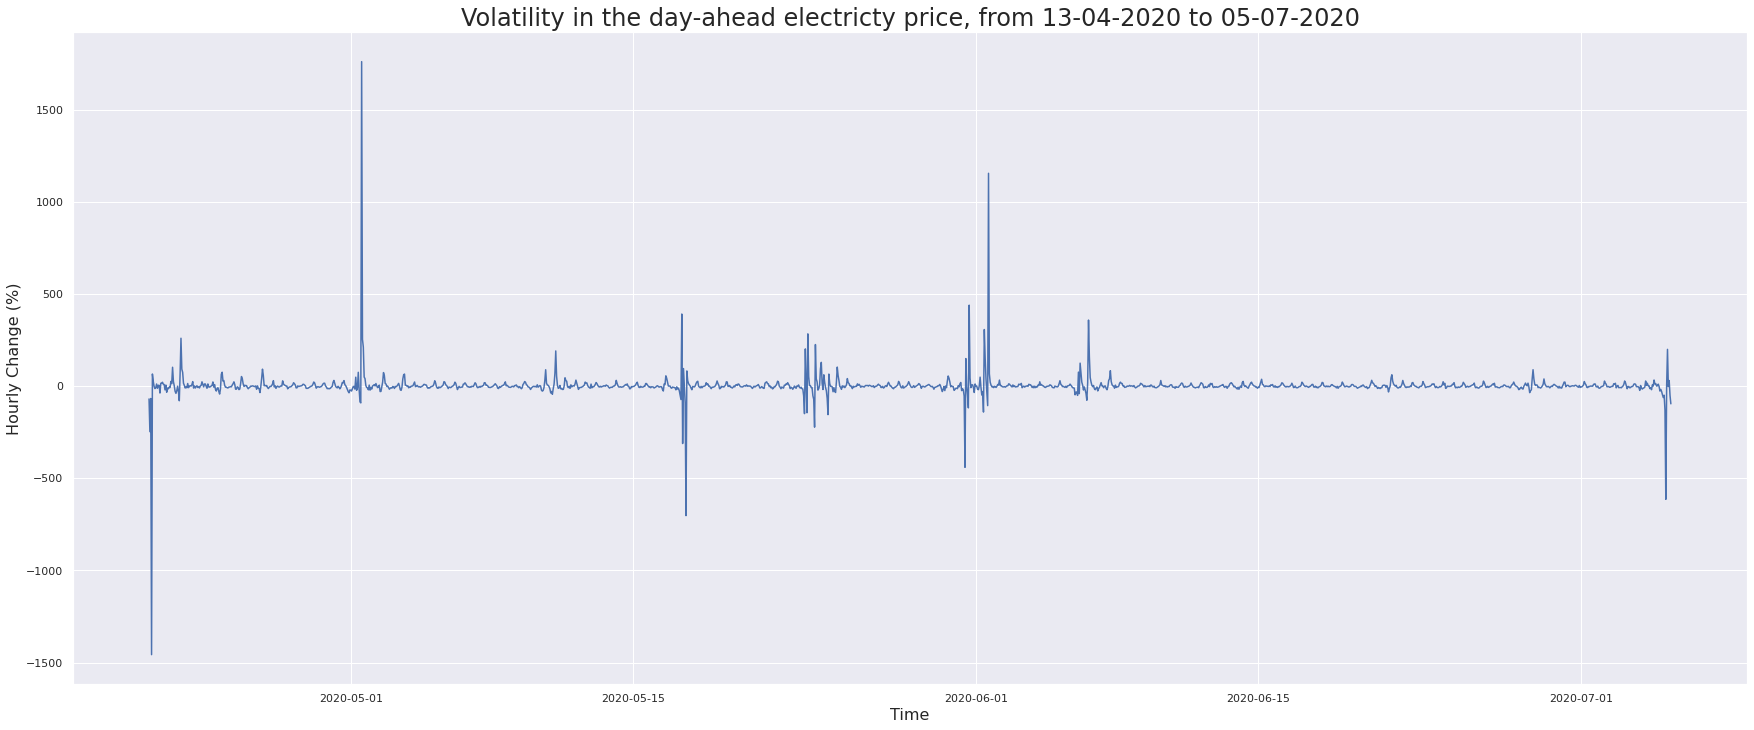

In [43]:
ax = plot_series(series=change6, ylabel='Hourly Change (%)', 
                 title='Volatility in the day-ahead electricty price, from 13-04-2020 to 05-07-2020')
plt.show()

In [44]:
change7 = change.loc['2020-07-05 13:00:00+00:00':] # Next, let's plot the rest of the time series, just after the unbelievably negative growth-rate, that happened at '2020-07-05 12:00:00+00:00' 
change7 # Note: series starts at 13:00 Uhr!

Date-Time
2020-07-05 13:00:00+00:00     70.826833
2020-07-05 14:00:00+00:00    -52.146119
2020-07-05 15:00:00+00:00   -165.076336
2020-07-05 16:00:00+00:00    110.117302
2020-07-05 17:00:00+00:00     63.782275
                                ...    
2021-03-12 18:00:00+00:00     -1.369634
2021-03-12 19:00:00+00:00     -0.118544
2021-03-12 20:00:00+00:00     -4.120041
2021-03-12 21:00:00+00:00     -5.570292
2021-03-12 22:00:00+00:00     -6.254682
Name: pricesCH, Length: 6010, dtype: float64

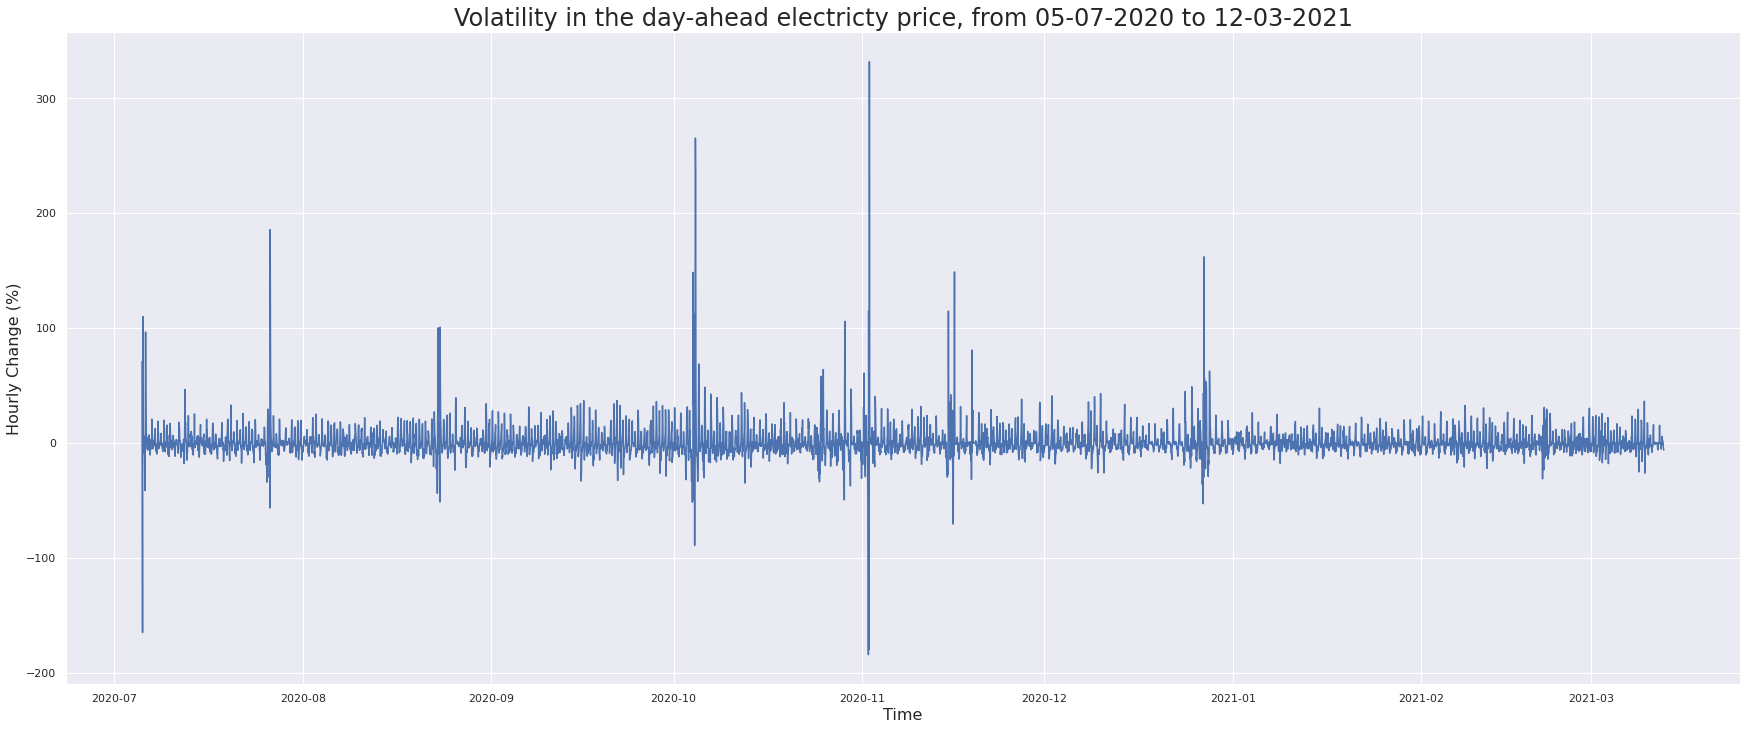

In [45]:
ax = plot_series(series=change7, ylabel='Hourly Change (%)', 
                 title='Volatility in the day-ahead electricty price, from 05-07-2020 to 12-03-2021')
plt.show()

### <u>Check the Distribution of the Day-Ahead Price</u>:

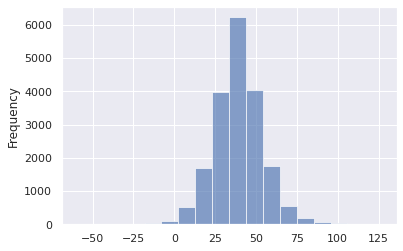

In [46]:
# Plot the histogram of the day-ahead electricity price

ax = df_energy['pricesCH'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the **day-ahead energy price practically follows a normal distribution** and thus, **could be standardized**. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series.

### <u>Time Series Decomposition and Stationarity Test</u>:

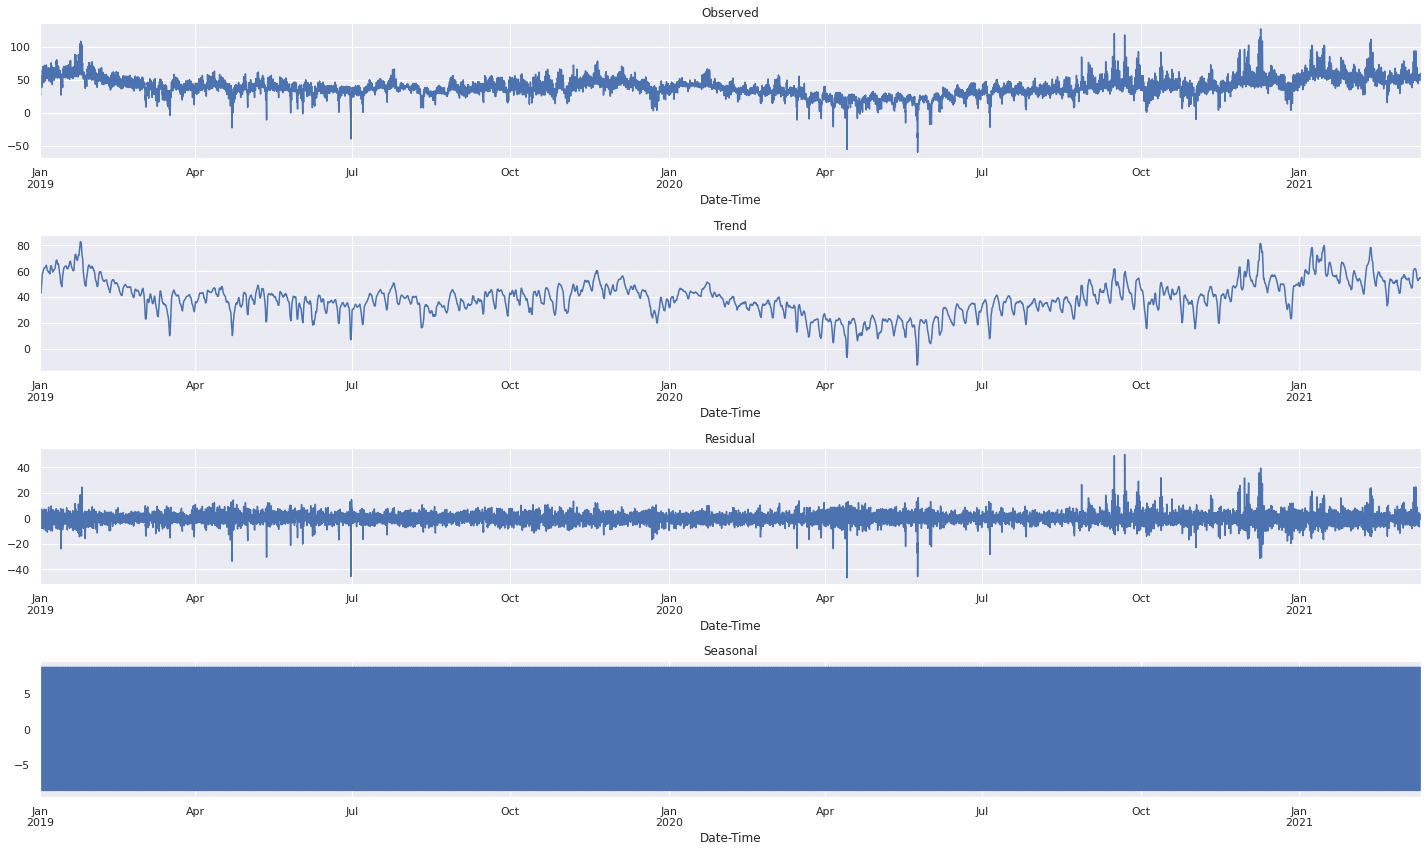

In [47]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['pricesCH'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

### <u>Make an Augmented Dickey-Fuller (ADF)-Test</u>:
    
The ADF-Test is a type of unit root test, that determines how strongly a time series is defined by a trend. Its hypotheses are the following:

- <strong>Null Hypothesis <em>H<sub>0</sub></em></strong>: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- <strong>Alternative Hypothesis <em>H<sub>1</sub></em></strong>: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [48]:
y = df_energy['pricesCH']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -6.520045
p-value: 0.000000
#Lags used: 45
Critical Value (1%): -3.430691
Critical Value (5%): -2.861691
Critical Value (10%): -2.566850


The ADF statistic (-6.520) is less than the critical value at 1% (-3.431) and thus, we can say that <strong>we reject the null hypothesis <em>H<sub>0</sub></em> with a significance level 1%</strong>, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

### <u>Make a Kwiatkowski-Phillips-Schmidt-Shin (KPSS)-Test</u>:

The KPSS-Test follows the opposite logic from Augmented Dickey-Fuller test and checks for stationarity. Its hypotheses are the following:

- <strong>Null Hypothesis <em>H<sub>0</sub></em></strong>: The time series is level, i.e. it is stationary around a constant.
- <strong>Alternative Hypothesis <em>H<sub>1</sub></em></strong>: There is a unit root in the time series and thus it not stationary.

In [49]:
kpss_test = kpss(y, regression='c', lags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 4.215387
p-value: 0.010000
#Lags used: 45
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


<ipython-input-49-76824cf6cfc4>:1: FutureWarning: the 'lags'' keyword is deprecated, use 'nlags' instead
  kpss_test = kpss(y, regression='c', lags='legacy')
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The KPSS statistic (4.215) is higher than the critical value at 1% (0.739) and thus, we can say that <strong>we cannot reject the null hypothesis <em>H<sub>0</sub></em> with a significance level 1%</strong>, meaning that the time series is stationary or stationary around a constant.

**Both tests concluded that the electricity price time series is stationary**.

### <u>Autocorrelation, partial autocorrelation and cross-correlation</u>:

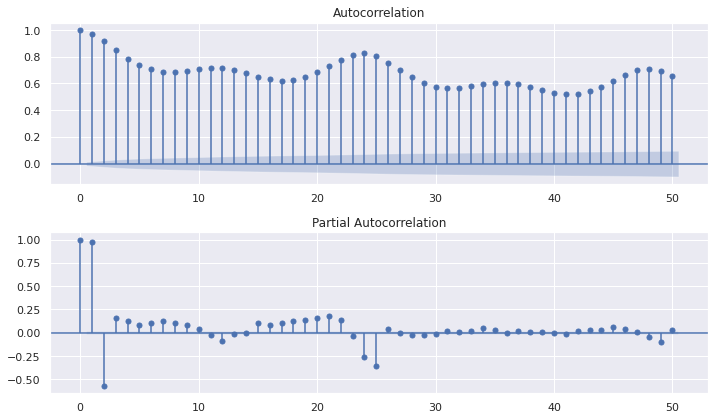

In [50]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_energy['pricesCH'], lags=50, ax=ax1)
plot_pacf(df_energy['pricesCH'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. **Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models**.

Nevertheless, it would quite definitely be more beneficial if we only chose to use specific past values (observations at certain time-lags) of a given feature, based on the cross-correlation between the electricity price and each one of the features in the dataset. For example, below we can see the cross-correlation between the electricity price and the Renewable Generation from Switzerland. We see that there are many time-lags with a correlation which is close to zero and could be ommited.

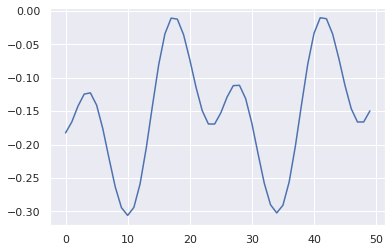

In [51]:
cross_corr = ccf(df_energy['RenGenCH'], df_energy['pricesCH'])
plt.plot(cross_corr[0:50])
plt.show()

For simplicity, we will just work with the correlations between the electricity price and the other features at each given hour.

In [52]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_energy.corr(method='pearson')
print(correlations['pricesCH'].sort_values(ascending=False).to_string())

pricesCH            1.000000
SeasonAndProduct    0.880006
LoadF               0.715202
LoadCH              0.637822
GenF                0.624032
LoadIT              0.595763
GenIT               0.561177
LoadD               0.557458
GenCH               0.555468
TransToIT           0.444241
GenD                0.328599
TransToDach         0.146220
RenGenF            -0.098994
RenGenIT           -0.153964
RenGenCH           -0.182590
RenGenD            -0.215956
TransFromDach      -0.261192


From the above, we can already see some very interesting correlations among the energy price that we want to predict and the rest of the features. For example, the total Swiss energy load and generation, is positively correlated with the electricity price. In contrast, the renewable generation (from wind &amp; solar) is negatively correlated with the energy price.

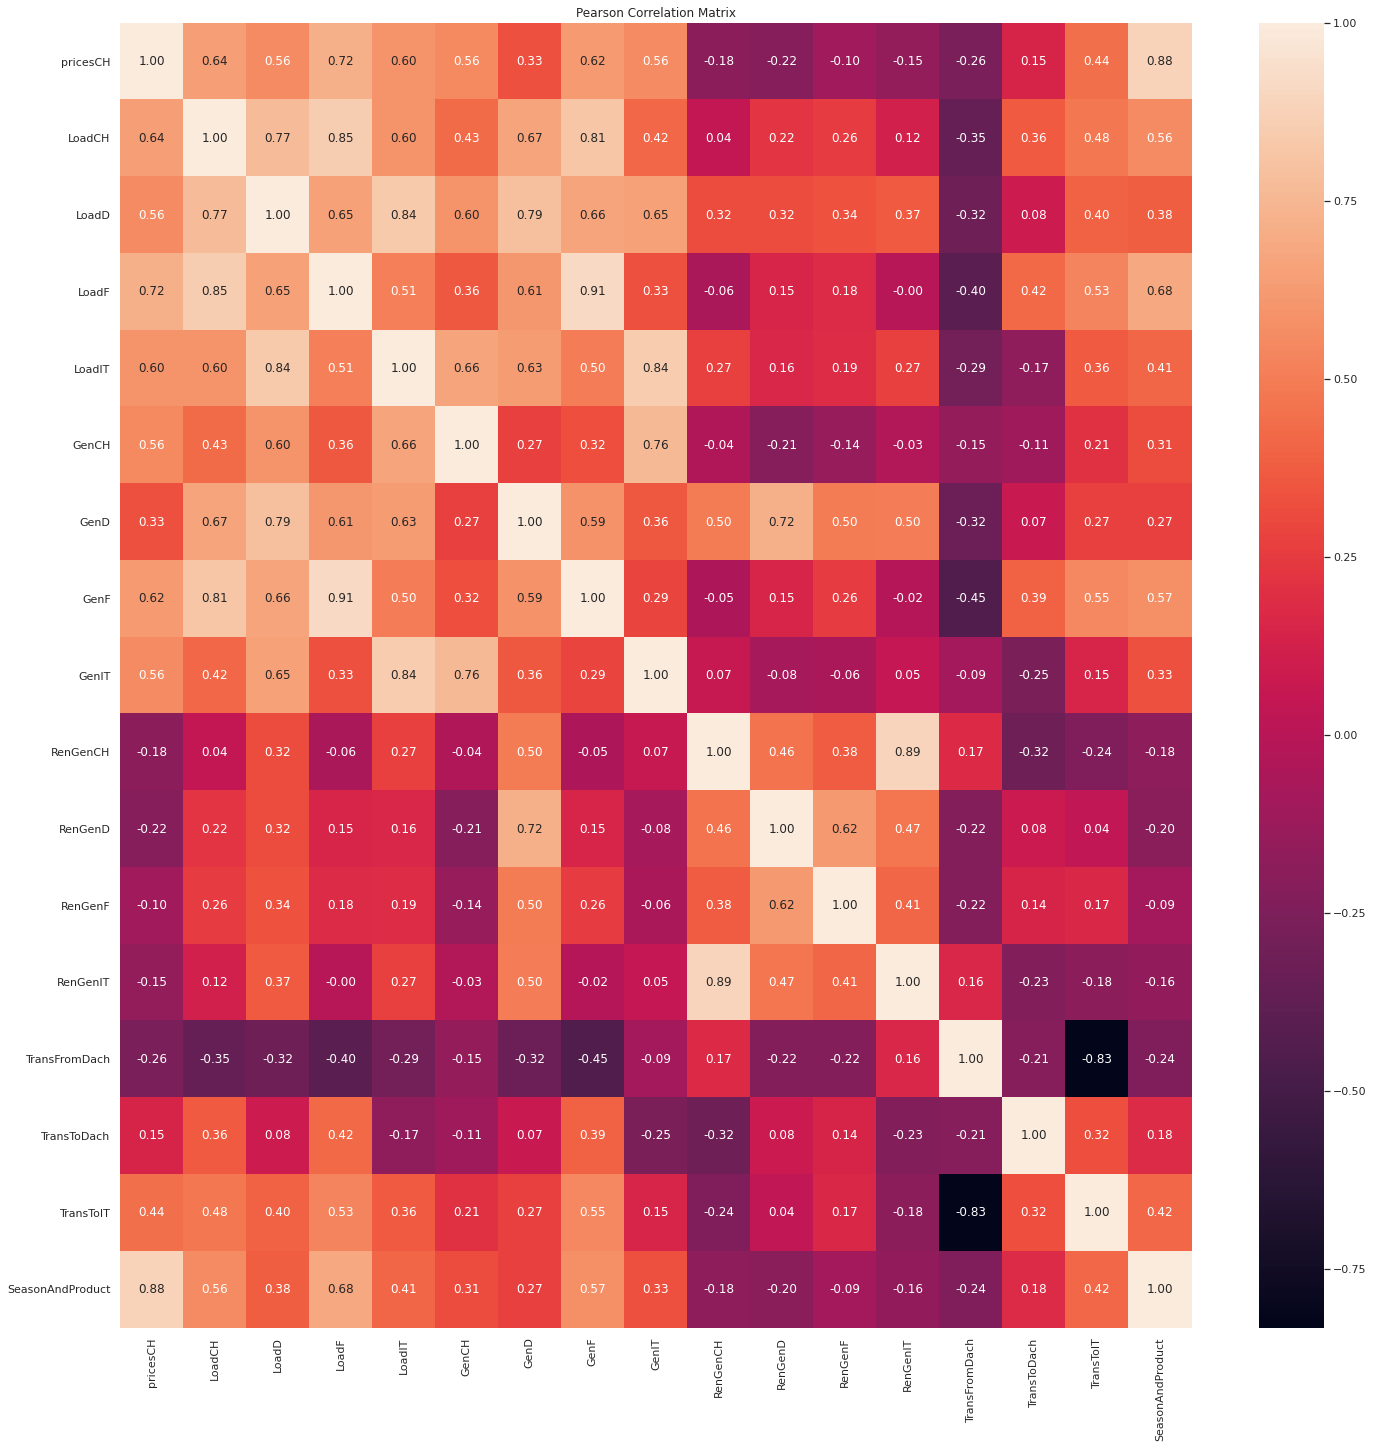

In [53]:
# Plot Pearson correlation matrix

correlations = df_energy.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While we cannot make a lot out of the above correlation matrix, we can observe that there quite a lot of features that are highly correlated with each other.

In [54]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

pricesCH          SeasonAndProduct    0.880006
LoadCH            LoadD               0.773913
                  LoadF               0.852378
                  GenF                0.814567
LoadD             LoadCH              0.773913
                  LoadIT              0.841008
                  GenD                0.787658
LoadF             LoadCH              0.852378
                  GenF                0.913837
LoadIT            LoadD               0.841008
                  GenIT               0.843148
GenCH             GenIT               0.759482
GenD              LoadD               0.787658
GenF              LoadCH              0.814567
                  LoadF               0.913837
GenIT             LoadIT              0.843148
                  GenCH               0.759482
RenGenCH          RenGenIT            0.889601
RenGenIT          RenGenCH            0.889601
SeasonAndProduct  pricesCH            0.880006


What we can observe, is that - apart from the seasonality in the day ahead prices - the most correlated features have to do with the load &amp; generation among the different countries.

## Chapter 3 - Load Day-Ahead Prices from France and Germany

Let's also load the day-ahead prices from Germany &amp; France, since those influence the Swiss prices.

In [55]:
# Read the datasets
data_DE = pd.read_csv("data/DE_LU.csv") # Diese Zeitreihe geht bis zum 5. Mai 2021, bis 23:45 Uhr 
data_FR = pd.read_csv('data/FR.csv') # Diese Zeitreihe geht bis zum 5. Mai 2021, bis 23:00 Uhr 

In [56]:
data_FR.tail() 

,Unnamed: 0,0
11778,2021-05-05 19:00:00+02:00,53900.0
11779,2021-05-05 20:00:00+02:00,52600.0
11780,2021-05-05 21:00:00+02:00,51200.0
11781,2021-05-05 22:00:00+02:00,50400.0
11782,2021-05-05 23:00:00+02:00,53650.0


In [57]:
data_DE.tail() # ACHTUNG: 1/4-Stunden Takt!!

,Unnamed: 0,0
47127,2021-05-05 22:45:00+02:00,56252.0
47128,2021-05-05 23:00:00+02:00,55036.0
47129,2021-05-05 23:15:00+02:00,53949.0
47130,2021-05-05 23:30:00+02:00,53426.0
47131,2021-05-05 23:45:00+02:00,52823.0


Re-name the columns:

In [58]:
data_DE = data_DE.rename(columns={"Unnamed: 0": "date", "0": "pricesDE"})

In [59]:
data_FR = data_FR.rename(columns={"Unnamed: 0": "date", "0": "pricesFRA"})

In [60]:
data_FR.tail()

,date,pricesFRA
11778,2021-05-05 19:00:00+02:00,53900.0
11779,2021-05-05 20:00:00+02:00,52600.0
11780,2021-05-05 21:00:00+02:00,51200.0
11781,2021-05-05 22:00:00+02:00,50400.0
11782,2021-05-05 23:00:00+02:00,53650.0


## Chapter 3 - Feature Engineering

Now, let's see whether we can create new feature from what we learned in chapter 2 - data visualization.

### <u>Feature Generation</u>: Creating Time-Dummies to control for Seasonality

The first features that we will generate for a given hour will just be that particular hour, the day and the month in which it falls into.

In [61]:
# Generate 'hour' and 'month' features

for i in range(len(df_energy)):
    position = df_energy.index[i]
    hour = position.hour
    month = position.month
    df_energy.loc[position, 'hour'] = hour
    df_energy.loc[position, 'month'] = month

In [62]:
# let's create a column 'date' which we will need for the construction of the next variable
df_energy = df_energy.reset_index()
df_energy['date'] = df_energy['Date-Time']
df_energy = df_energy.set_index('Date-Time')

In [63]:
# Generate 'Quarter', 'Hour' and 'day_of_week' features

df_energy['Quarter'] = df_energy['date'].apply(lambda x: x.quarter) # Werte von 1 [Januar bis März] bis 4 [Oktober bis Dezember]
df_energy['Hour'] = df_energy['date'].apply(lambda x: x.hour) # Werte von 0 [= Stunde 0:00-1:00] bis 23 [= Stunde 23:00-24:00]
df_energy['day_of_week'] = df_energy['date'].apply(lambda x: x.weekday()) # Werte von 0 [= Montag] bis 6 [= Sonntag]

In [64]:
df_energy

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,...,TransFromDach,TransToDach,TransToIT,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week
Date-Time,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:00:00+00:00,50.26,8600.0,43628.000000,63450.0,11110.0,3736.0,57054.0,64931.0,7833.0,2.0,...,2487.0,5900.0,2513.0,43.054583,23.0,12.0,2018-12-31 23:00:00+00:00,4,23,0
2019-01-01 00:00:00+00:00,48.74,7732.0,41662.750000,60800.0,10675.0,3599.0,57400.0,63555.0,6894.0,2.0,...,2487.0,5900.0,2513.0,43.054583,0.0,1.0,2019-01-01 00:00:00+00:00,1,0,1
2019-01-01 01:00:00+00:00,47.24,7563.0,40553.000000,59950.0,10080.0,3599.0,57275.0,62104.0,6022.0,2.0,...,2487.0,5900.0,2513.0,43.054583,1.0,1.0,2019-01-01 01:00:00+00:00,1,1,1
2019-01-01 02:00:00+00:00,36.29,7379.0,40261.250000,56400.0,9793.0,3600.0,58024.0,59954.0,4649.0,2.0,...,2487.0,5900.0,2513.0,43.054583,2.0,1.0,2019-01-01 02:00:00+00:00,1,2,1
2019-01-01 03:00:00+00:00,30.09,6996.0,40603.250000,53550.0,9485.0,3600.0,59301.0,56724.0,4679.0,2.0,...,2487.0,5900.0,2513.0,43.054583,3.0,1.0,2019-01-01 03:00:00+00:00,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12 18:00:00+00:00,59.05,8169.0,60146.369003,64800.0,24042.0,5352.0,80379.0,69127.0,15039.0,0.0,...,2.0,6400.0,4183.0,54.878333,18.0,3.0,2021-03-12 18:00:00+00:00,1,18,4
2021-03-12 19:00:00+00:00,58.98,7831.0,57628.045139,62900.0,22097.0,5042.0,77341.0,69146.0,12809.0,0.0,...,2.0,6400.0,4183.0,54.878333,19.0,3.0,2021-03-12 19:00:00+00:00,1,19,4
2021-03-12 20:00:00+00:00,56.55,7610.0,55076.522096,59200.0,19951.0,4172.0,74198.0,65641.0,11166.0,0.0,...,2.0,6400.0,4183.0,54.878333,20.0,3.0,2021-03-12 20:00:00+00:00,1,20,4


#### <u>Preparing grouping-categories</u>:

As we want to examine the data with respect to "seasonality" and "product", we will create categories for those.

<u>Seasonality means</u>:
1. **Summer time** - April to September, e.g. **2nd and 3rd quarters**.
2. **Winter time** - October to March, e.g. **1st and 4th quarters**.

<u>Product means</u>:
1. **peak time** - thats the time of working hours **Monday to Friday, hour 8 to hour 20**
2. **off-peak time** - that means the **complement of peak hours (incl. _entire_ 24 weekend hours)**

The quarter of the year and the hour of the day were defined in a previous cell. They will be used here. 

We will define two new columns which define the summer/winter time and peak/off-peak time. After that, the dataframe can be filtered to specific needs. (This is a more general solution than defining the summer/winter time for each year)

In [65]:
# Define 2 conditions (delimited by a comma):
conditions  = [(df_energy["Hour"] > 7) & (df_energy["Hour"] < 20) & (df_energy["day_of_week"] < 5), 
               ((df_energy["Hour"] < 8) | (df_energy["Hour"] > 19) & (df_energy["day_of_week"] < 5)) | (df_energy["day_of_week"] > 4) ]
choices     = ["peak","off-peak"] # we have 2 "choices" (aka 2 categories)

# Create the new column, which categorizes whether we have an 'off-peak' day-ahead price or a 'peak' day-ahead price:
df_energy["Peak_offpeak"] = np.select(conditions, choices, default=np.nan) # apply the 2 conditions to categorize the data

In [66]:
# check if it worked:
df_energy[
    df_energy['day_of_week'] == 4 # you can change this number to check if it worked --> 0-4 == Wochentage, Mo-Fr; 5-6 == Weekend, Sa-So
].head(25)

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,...,TransToDach,TransToIT,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week,Peak_offpeak
Date-Time,,,,,,,,,,,,,,,,,,,,,
2019-01-04 00:00:00+00:00,51.69,7729.0,44568.75,68900.0,12523.0,3685.0,58000.0,70611.0,5523.0,8.0,...,5900.0,2246.0,63.257917,0.0,1.0,2019-01-04 00:00:00+00:00,1,0,4,off-peak
2019-01-04 01:00:00+00:00,49.95,7820.0,43809.25,68050.0,12053.0,3601.0,58174.0,70072.0,4916.0,7.0,...,5900.0,2246.0,63.257917,1.0,1.0,2019-01-04 01:00:00+00:00,1,1,4,off-peak
2019-01-04 02:00:00+00:00,48.41,7804.0,43997.00,65750.0,12024.0,3596.0,60025.0,68381.0,4630.0,6.0,...,5900.0,2160.0,63.257917,2.0,1.0,2019-01-04 02:00:00+00:00,1,2,4,off-peak
2019-01-04 03:00:00+00:00,48.12,7273.0,45005.25,64650.0,12185.0,3600.0,62019.0,67736.0,4649.0,7.0,...,5900.0,2160.0,63.257917,3.0,1.0,2019-01-04 03:00:00+00:00,1,3,4,off-peak
2019-01-04 04:00:00+00:00,50.33,7996.0,47293.00,65850.0,12877.0,3604.0,64901.0,69460.0,6435.0,8.0,...,5900.0,2160.0,63.257917,4.0,1.0,2019-01-04 04:00:00+00:00,1,4,4,off-peak
2019-01-04 05:00:00+00:00,54.03,7932.0,52077.00,69250.0,14922.0,3840.0,68794.0,73570.0,8477.0,8.0,...,5900.0,1781.0,63.257917,5.0,1.0,2019-01-04 05:00:00+00:00,1,5,4,off-peak
2019-01-04 06:00:00+00:00,65.95,7826.0,57027.75,73700.0,17890.0,4999.0,71937.0,75539.0,11111.0,8.0,...,5900.0,1891.0,63.257917,6.0,1.0,2019-01-04 06:00:00+00:00,1,6,4,off-peak
2019-01-04 07:00:00+00:00,69.92,8141.0,60183.50,77250.0,20084.0,7146.0,76409.0,77276.0,12634.0,12.0,...,5900.0,1891.0,63.257917,7.0,1.0,2019-01-04 07:00:00+00:00,1,7,4,off-peak
2019-01-04 08:00:00+00:00,70.00,8194.0,61176.75,78600.0,21084.0,7506.0,78059.0,79049.0,12089.0,30.0,...,5900.0,2523.0,63.257917,8.0,1.0,2019-01-04 08:00:00+00:00,1,8,4,peak


We have generated the `peak hour` and `offpeak hour` feature. However, it may be necessary to additionally differentiate between `summer` and `winter`, since prices during peak &amp; offpeak season in summer tend to be lower than in the winter. Thus, it is useful to also **differentiate between winter and summer**:

In [67]:
# Define the 4 categories, based on summer/winter and peak/off-peak time (delimited by commas):
conditions  = [(df_energy["Peak_offpeak"] == "peak") & (df_energy["Quarter"] == 2) | (df_energy["Quarter"] == 3), 
               (df_energy["Peak_offpeak"] == "off-peak") & (df_energy["Quarter"] == 2) | (df_energy["Quarter"] == 3),
               (df_energy["Peak_offpeak"] == "peak") & (df_energy["Quarter"] == 1) | (df_energy["Quarter"] == 4), 
               (df_energy["Peak_offpeak"] == "off-peak") & (df_energy["Quarter"] == 1) | (df_energy["Quarter"] == 4)]
choices     = ["summer_peak", "summer_offpeak", "winter_peak", "winter_offpeak"]  # we have 4 "choices" (aka 4 categories)

# Create the new column, which categorizes whether we have an 'off-peak summer / winter' day-ahead price or a 'peak summer / winter' day-ahead price:
df_energy["category"] = np.select(conditions, choices, default=np.nan)

In [68]:
# check if it worked:
df_energy[
    (df_energy['day_of_week'] == 4) # you can change this number to check if it worked --> 0-4 == Wochentage, Mo-Fr; 5-6 == Weekend, Sa-So
    & (df_energy['Quarter'] == 1) # you can also change this number to check if it worked --> 2-3 == summer; 1 & 4 == winter;
].head(25)

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,...,TransToIT,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week,Peak_offpeak,category
Date-Time,,,,,,,,,,,,,,,,,,,,,
2019-01-04 00:00:00+00:00,51.69,7729.0,44568.75,68900.0,12523.0,3685.0,58000.0,70611.0,5523.0,8.0,...,2246.0,63.257917,0.0,1.0,2019-01-04 00:00:00+00:00,1,0,4,off-peak,winter_offpeak
2019-01-04 01:00:00+00:00,49.95,7820.0,43809.25,68050.0,12053.0,3601.0,58174.0,70072.0,4916.0,7.0,...,2246.0,63.257917,1.0,1.0,2019-01-04 01:00:00+00:00,1,1,4,off-peak,winter_offpeak
2019-01-04 02:00:00+00:00,48.41,7804.0,43997.00,65750.0,12024.0,3596.0,60025.0,68381.0,4630.0,6.0,...,2160.0,63.257917,2.0,1.0,2019-01-04 02:00:00+00:00,1,2,4,off-peak,winter_offpeak
2019-01-04 03:00:00+00:00,48.12,7273.0,45005.25,64650.0,12185.0,3600.0,62019.0,67736.0,4649.0,7.0,...,2160.0,63.257917,3.0,1.0,2019-01-04 03:00:00+00:00,1,3,4,off-peak,winter_offpeak
2019-01-04 04:00:00+00:00,50.33,7996.0,47293.00,65850.0,12877.0,3604.0,64901.0,69460.0,6435.0,8.0,...,2160.0,63.257917,4.0,1.0,2019-01-04 04:00:00+00:00,1,4,4,off-peak,winter_offpeak
2019-01-04 05:00:00+00:00,54.03,7932.0,52077.00,69250.0,14922.0,3840.0,68794.0,73570.0,8477.0,8.0,...,1781.0,63.257917,5.0,1.0,2019-01-04 05:00:00+00:00,1,5,4,off-peak,winter_offpeak
2019-01-04 06:00:00+00:00,65.95,7826.0,57027.75,73700.0,17890.0,4999.0,71937.0,75539.0,11111.0,8.0,...,1891.0,63.257917,6.0,1.0,2019-01-04 06:00:00+00:00,1,6,4,off-peak,winter_offpeak
2019-01-04 07:00:00+00:00,69.92,8141.0,60183.50,77250.0,20084.0,7146.0,76409.0,77276.0,12634.0,12.0,...,1891.0,63.257917,7.0,1.0,2019-01-04 07:00:00+00:00,1,7,4,off-peak,winter_offpeak
2019-01-04 08:00:00+00:00,70.00,8194.0,61176.75,78600.0,21084.0,7506.0,78059.0,79049.0,12089.0,30.0,...,2523.0,63.257917,8.0,1.0,2019-01-04 08:00:00+00:00,1,8,4,peak,winter_peak


Another differentiation we need to make, is whether we are in the weekend or not, since prices tend to be higher in `peak`- and `offpeak`-hours during the weak compared to the weekends.

In particular, for a particular given hour, the value of `weekend` will be equal to **0**, if the hours falls *during a weekday* (= Monday-Friday), equal to **1** if the *hour falls on a Saturday* and equal to **2** if the *hour falls on a Sunday*:

In [69]:
# Generate 'weekend' feature

for i in range(len(df_energy)):
    position = df_energy.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_energy.loc[position, 'weekend'] = 2
    elif (weekday == 5):
        df_energy.loc[position, 'weekend'] = 1
    else:
        df_energy.loc[position, 'weekend'] = 0

In [70]:
# check if it worked:
df_energy[
    df_energy['day_of_week'] == 6 # you can change this number to check if it worked --> 0-4 == Wochentage, Mo-Fr; 5-6 == Weekend, Sa-So
].head(25)

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,...,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week,Peak_offpeak,category,weekend
Date-Time,,,,,,,,,,,,,,,,,,,,,
2019-01-06 00:00:00+00:00,58.94,7590.0,44073.25,67550.0,11604.0,3581.0,59724.0,68757.0,6067.0,6.0,...,59.059583,0.0,1.0,2019-01-06 00:00:00+00:00,1,0,6,off-peak,winter_offpeak,2.0
2019-01-06 01:00:00+00:00,54.74,7057.0,43196.00,66400.0,10922.0,3574.0,59601.0,66660.0,5690.0,6.0,...,59.059583,1.0,1.0,2019-01-06 01:00:00+00:00,1,1,6,off-peak,winter_offpeak,2.0
2019-01-06 02:00:00+00:00,50.55,7065.0,42884.25,62750.0,10657.0,3594.0,57553.0,64585.0,5142.0,6.0,...,59.059583,2.0,1.0,2019-01-06 02:00:00+00:00,1,2,6,off-peak,winter_offpeak,2.0
2019-01-06 03:00:00+00:00,49.85,7832.0,43092.00,60650.0,10519.0,3593.0,55729.0,65099.0,5139.0,6.0,...,59.059583,3.0,1.0,2019-01-06 03:00:00+00:00,1,3,6,off-peak,winter_offpeak,2.0
2019-01-06 04:00:00+00:00,48.13,7541.0,42527.50,60150.0,10814.0,3586.0,56436.0,64704.0,5706.0,8.0,...,59.059583,4.0,1.0,2019-01-06 04:00:00+00:00,1,4,6,off-peak,winter_offpeak,2.0
2019-01-06 05:00:00+00:00,51.52,7360.0,41990.75,61050.0,11224.0,3600.0,56707.0,65273.0,5750.0,8.0,...,59.059583,5.0,1.0,2019-01-06 05:00:00+00:00,1,5,6,off-peak,winter_offpeak,2.0
2019-01-06 06:00:00+00:00,54.35,7780.0,43700.25,62200.0,11795.0,3666.0,58117.0,65387.0,6402.0,9.0,...,59.059583,6.0,1.0,2019-01-06 06:00:00+00:00,1,6,6,off-peak,winter_offpeak,2.0
2019-01-06 07:00:00+00:00,55.06,7146.0,46796.25,63950.0,11949.0,3656.0,59607.0,66292.0,6846.0,10.0,...,59.059583,7.0,1.0,2019-01-06 07:00:00+00:00,1,7,6,off-peak,winter_offpeak,2.0
2019-01-06 08:00:00+00:00,57.53,7545.0,50064.00,65650.0,12970.0,3724.0,61588.0,69142.0,7308.0,19.0,...,59.059583,8.0,1.0,2019-01-06 08:00:00+00:00,1,8,6,off-peak,winter_offpeak,2.0


### <u>Feature Selection</u>:

In [71]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

#### <u>Setting the Indezes correctly for Train-Test-Split</u>:

Next, we need to examine, *where* we will do the temporal train-test-split of our data. 

- <u>Rule of Thumb 1</u>: **Usually, we need a 80-20 split of our data**.
- <u>Rule of Thumb 2</u>: **You need to make sure all datasets (training, validation and test) end at the exact same hour**.

First, we need to check how many observations we have in total:

In [72]:
df_energy.shape # should have: 19'248 rows // observations and 27 columns in total

(19248, 26)

Since we have 19'248 observations, it implies that the training-data should approximately end at 15'398 observations (= 0.8 * 19'248), which would be the *03. Oktober 2020, at 12:00 o'clock*.

Next, we need to check the very last observation in our dataset, **because - according to rule of thum 2 - we will want to do a split at the <u>same</u> hours for our trainig-, validation- and test-set**:

##### <u>Test-Set Index</u>:

In [73]:
df_energy[-1:] # end of dataset: 12.03.2021, um 22:00 Uhr;

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,...,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week,Peak_offpeak,category,weekend
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-03-12 22:00:00+00:00,50.06,7508.0,49413.789457,60200.0,16445.0,3289.0,68464.0,65403.0,7507.0,0.0,...,54.878333,22.0,3.0,2021-03-12 22:00:00+00:00,1,22,4,off-peak,winter_offpeak,0.0


##### <u>Trainings-Set Index</u>:

Since the **_whole_ dataset *ends at the 12th March 2021, 22:00 o'clock***, I will take the **12.th of September 2020, 22:00 o'clock (= 77.43% of the total dataset)** for my training-dataset.

In [74]:
df_energy[:14904].tail(1) # check: 12.09.2020, 22:00 Uhr entspricht 14'904 rows; Dies entspricht circa 77.43% (= 14'904 / 19'248) des Datensatzes.

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,...,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week,Peak_offpeak,category,weekend
Date-Time,,,,,,,,,,,,,,,,,,,,,
2020-09-12 22:00:00+00:00,37.51,6082.0,38624.0,40350.0,13307.0,3378.0,36349.0,38920.0,10785.0,0.0,...,35.407083,22.0,9.0,2020-09-12 22:00:00+00:00,3,22,5,off-peak,summer_peak,1.0


##### <u>Validation-Set Index</u>:

Since we used 77.43% of our dataset for the training-set, there will be approximately 11.29% (= [1- 0.7743] / 2 ), e.g. until row 17'077 (= [11.29% * 19248 = 2173] + 14'904 rows), which corresponds to the *12-th December 2020, 11:00 o'clock*, as we see here:

In [75]:
df_energy[:17077].tail(1) # check: 12.12.2020, 11:00 Uhr entspricht 17'077 rows;

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,...,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week,Peak_offpeak,category,weekend
Date-Time,,,,,,,,,,,,,,,,,,,,,
2020-12-12 11:00:00+00:00,54.92,8014.0,59147.25,65700.0,19461.0,4593.0,51367.0,70378.0,12242.0,27.0,...,50.313333,11.0,12.0,2020-12-12 11:00:00+00:00,4,11,5,off-peak,winter_peak,1.0


Since we need the validation-set to end at 22:00 o'clock (according to rule-of-thumb 2), we will take the **11-th December, 22:00 o'clock** for the validation set. This corresponds to **17'064 rows, e.g. 11.22% of the total dataset (= [17064 / 19'248] - 0.7743)**:

In [76]:
df_energy[:17064].tail(1)

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,...,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week,Peak_offpeak,category,weekend
Date-Time,,,,,,,,,,,,,,,,,,,,,
2020-12-11 22:00:00+00:00,47.03,7703.0,52955.5,65350.0,16815.0,2831.0,56723.0,67843.0,11536.0,0.0,...,53.9425,22.0,12.0,2020-12-11 22:00:00+00:00,4,22,4,off-peak,winter_peak,0.0


In [77]:
train_end_idx = 14904 # 12.September 2020, 22:00 Uhr; Train-Test-Split: circa bei 80-zu-20%. Tatsächlicher Split: 77.43%. Endet um 22:00 Uhr, weil das Test-Set um 22:00 Uhr endet!
cv_end_idx = 17064 # 11. Dezember 2020, 22:00 Uhr; Cross-Validation entspricht circa 11.22% des Datensatzes (88.65% - 77.43% = 11.22 %) UND endet bei 22:00 Uhr, weil das Test-Set bei 22:00 Uhr endet!
test_end_idx = 19248 # 12. März 2021, 22:00 Uhr; dies entspricht circa 11.35% (= 1- 77.43% - 11.22%) des restlichen Datensatzes... 

In [83]:
pd.set_option("display.max.columns", None) # this will tell Python: "show me ALL the columns!"
df_energy

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,RenGenD,RenGenF,RenGenIT,TransFromDach,TransToDach,TransToIT,SeasonAndProduct,hour,month,date,Quarter,Hour,day_of_week,Peak_offpeak,category,weekend
Date-Time,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:00:00+00:00,50.26,8600.0,43628.000000,63450.0,11110.0,3736.0,57054.0,64931.0,7833.0,2.0,23948.75,1698.0,3.0,2487.0,5900.0,2513.0,43.054583,23.0,12.0,2018-12-31 23:00:00+00:00,4,23,0,off-peak,winter_peak,0.0
2019-01-01 00:00:00+00:00,48.74,7732.0,41662.750000,60800.0,10675.0,3599.0,57400.0,63555.0,6894.0,2.0,25668.75,1680.0,3.0,2487.0,5900.0,2513.0,43.054583,0.0,1.0,2019-01-01 00:00:00+00:00,1,0,1,off-peak,winter_offpeak,0.0
2019-01-01 01:00:00+00:00,47.24,7563.0,40553.000000,59950.0,10080.0,3599.0,57275.0,62104.0,6022.0,2.0,27384.00,1675.0,2.0,2487.0,5900.0,2513.0,43.054583,1.0,1.0,2019-01-01 01:00:00+00:00,1,1,1,off-peak,winter_offpeak,0.0
2019-01-01 02:00:00+00:00,36.29,7379.0,40261.250000,56400.0,9793.0,3600.0,58024.0,59954.0,4649.0,2.0,29010.25,1670.0,2.0,2487.0,5900.0,2513.0,43.054583,2.0,1.0,2019-01-01 02:00:00+00:00,1,2,1,off-peak,winter_offpeak,0.0
2019-01-01 03:00:00+00:00,30.09,6996.0,40603.250000,53550.0,9485.0,3600.0,59301.0,56724.0,4679.0,2.0,30359.25,1664.0,2.0,2487.0,5900.0,2513.0,43.054583,3.0,1.0,2019-01-01 03:00:00+00:00,1,3,1,off-peak,winter_offpeak,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12 18:00:00+00:00,59.05,8169.0,60146.369003,64800.0,24042.0,5352.0,80379.0,69127.0,15039.0,0.0,37634.25,11101.0,7.0,2.0,6400.0,4183.0,54.878333,18.0,3.0,2021-03-12 18:00:00+00:00,1,18,4,peak,winter_peak,0.0
2021-03-12 19:00:00+00:00,58.98,7831.0,57628.045139,62900.0,22097.0,5042.0,77341.0,69146.0,12809.0,0.0,38597.50,11009.0,8.0,2.0,6400.0,4183.0,54.878333,19.0,3.0,2021-03-12 19:00:00+00:00,1,19,4,peak,winter_peak,0.0
2021-03-12 20:00:00+00:00,56.55,7610.0,55076.522096,59200.0,19951.0,4172.0,74198.0,65641.0,11166.0,0.0,38854.50,10918.0,7.0,2.0,6400.0,4183.0,54.878333,20.0,3.0,2021-03-12 20:00:00+00:00,1,20,4,off-peak,winter_offpeak,0.0


- <u>Achtung</u>: Bevor wir weiterfahren können, darf im Data-Frame **keine einzige kategorische Variable auftauchen**! Aktuell wären die Spalten `Peak_offpeak`, sowie `category` unbrauchbar!
- <u>TO-DOs</u>:
    - Drop the `date`-column, since I only needed it to construct dummies, such as `Quarter`, `hour`, `day_of_week`...
    - Make simple dummies out of all the categorical-variables.

In [84]:
df_energy = df_energy.drop(['date'], axis=1)
df_energy # check: should only be 25 columns left? --> yes!

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,RenGenD,RenGenF,RenGenIT,TransFromDach,TransToDach,TransToIT,SeasonAndProduct,hour,month,Quarter,Hour,day_of_week,Peak_offpeak,category,weekend
Date-Time,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:00:00+00:00,50.26,8600.0,43628.00,63450.0,11110.0,3736.0,57054.0,64931.0,7833.0,2.0,23948.75,1698.0,3.0,2487.0,5900.0,2513.0,43.054583,23.0,12.0,4,23,0,off-peak,winter_peak,0.0
2019-01-01 00:00:00+00:00,48.74,7732.0,41662.75,60800.0,10675.0,3599.0,57400.0,63555.0,6894.0,2.0,25668.75,1680.0,3.0,2487.0,5900.0,2513.0,43.054583,0.0,1.0,1,0,1,off-peak,winter_offpeak,0.0
2019-01-01 01:00:00+00:00,47.24,7563.0,40553.00,59950.0,10080.0,3599.0,57275.0,62104.0,6022.0,2.0,27384.00,1675.0,2.0,2487.0,5900.0,2513.0,43.054583,1.0,1.0,1,1,1,off-peak,winter_offpeak,0.0
2019-01-01 02:00:00+00:00,36.29,7379.0,40261.25,56400.0,9793.0,3600.0,58024.0,59954.0,4649.0,2.0,29010.25,1670.0,2.0,2487.0,5900.0,2513.0,43.054583,2.0,1.0,1,2,1,off-peak,winter_offpeak,0.0
2019-01-01 03:00:00+00:00,30.09,6996.0,40603.25,53550.0,9485.0,3600.0,59301.0,56724.0,4679.0,2.0,30359.25,1664.0,2.0,2487.0,5900.0,2513.0,43.054583,3.0,1.0,1,3,1,off-peak,winter_offpeak,0.0


### <u>Use Dataframe with only `SeasonAndProduct` - but none of the newly created Time-Features</u>:

In [115]:
df_energy_SeasAndProd = df_energy.drop(['hour', 'month', 'Quarter', 'Hour', 'day_of_week', 'Peak_offpeak', 'category', 'weekend'], axis=1)
df_energy_SeasAndProd # check: should only be 17 columns left? --> yes!

,pricesCH,LoadCH,LoadD,LoadF,LoadIT,GenCH,GenD,GenF,GenIT,RenGenCH,RenGenD,RenGenF,RenGenIT,TransFromDach,TransToDach,TransToIT,SeasonAndProduct
Date-Time,,,,,,,,,,,,,,,,,
2018-12-31 23:00:00+00:00,50.26,8600.0,43628.000000,63450.0,11110.0,3736.0,57054.0,64931.0,7833.0,2.0,23948.75,1698.0,3.0,2487.0,5900.0,2513.0,43.054583
2019-01-01 00:00:00+00:00,48.74,7732.0,41662.750000,60800.0,10675.0,3599.0,57400.0,63555.0,6894.0,2.0,25668.75,1680.0,3.0,2487.0,5900.0,2513.0,43.054583
2019-01-01 01:00:00+00:00,47.24,7563.0,40553.000000,59950.0,10080.0,3599.0,57275.0,62104.0,6022.0,2.0,27384.00,1675.0,2.0,2487.0,5900.0,2513.0,43.054583
2019-01-01 02:00:00+00:00,36.29,7379.0,40261.250000,56400.0,9793.0,3600.0,58024.0,59954.0,4649.0,2.0,29010.25,1670.0,2.0,2487.0,5900.0,2513.0,43.054583
2019-01-01 03:00:00+00:00,30.09,6996.0,40603.250000,53550.0,9485.0,3600.0,59301.0,56724.0,4679.0,2.0,30359.25,1664.0,2.0,2487.0,5900.0,2513.0,43.054583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12 18:00:00+00:00,59.05,8169.0,60146.369003,64800.0,24042.0,5352.0,80379.0,69127.0,15039.0,0.0,37634.25,11101.0,7.0,2.0,6400.0,4183.0,54.878333
2021-03-12 19:00:00+00:00,58.98,7831.0,57628.045139,62900.0,22097.0,5042.0,77341.0,69146.0,12809.0,0.0,38597.50,11009.0,8.0,2.0,6400.0,4183.0,54.878333
2021-03-12 20:00:00+00:00,56.55,7610.0,55076.522096,59200.0,19951.0,4172.0,74198.0,65641.0,11166.0,0.0,38854.50,10918.0,7.0,2.0,6400.0,4183.0,54.878333


In [116]:
df_energy_SeasAndProd.info() # check: are all variables from the type 'float64'? --> yes!

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19248 entries, 2018-12-31 23:00:00+00:00 to 2021-03-12 22:00:00+00:00
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pricesCH          19248 non-null  float64
 1   LoadCH            19248 non-null  float64
 2   LoadD             19248 non-null  float64
 3   LoadF             19248 non-null  float64
 4   LoadIT            19248 non-null  float64
 5   GenCH             19248 non-null  float64
 6   GenD              19248 non-null  float64
 7   GenF              19248 non-null  float64
 8   GenIT             19248 non-null  float64
 9   RenGenCH          19248 non-null  float64
 10  RenGenD           19248 non-null  float64
 11  RenGenF           19248 non-null  float64
 12  RenGenIT          19248 non-null  float64
 13  TransFromDach     19248 non-null  float64
 14  TransToDach       19248 non-null  float64
 15  TransToIT         19248 non-null  float6

In [117]:
X_SeasAndProd = df_energy_SeasAndProd[df_energy_SeasAndProd.columns.drop('pricesCH')].values
y_SeasAndProd = df_energy_SeasAndProd['pricesCH'].values

y_SeasAndProd = y_SeasAndProd.reshape(-1, 1)

#### <u>Scaling all Variables</u>:

In [118]:
scaler_X_SeasAndProd = MinMaxScaler(feature_range=(0, 1))
scaler_y_SeasAndProd = MinMaxScaler(feature_range=(0, 1))

In [119]:
scaler_X_SeasAndProd.fit(X_SeasAndProd[:train_end_idx])
scaler_y_SeasAndProd.fit(y_SeasAndProd[:train_end_idx])

MinMaxScaler()

In [120]:
X_norm_SeasAndProd = scaler_X_SeasAndProd.transform(X_SeasAndProd)
y_norm_SeasAndProd = scaler_y_SeasAndProd.transform(y_SeasAndProd)

#### <u>Pincipal Component Analysis</u>:

In [121]:
pca_SeasAndProd = PCA()
X_pca_SeasAndProd = pca_SeasAndProd.fit(X_norm_SeasAndProd[:train_end_idx])

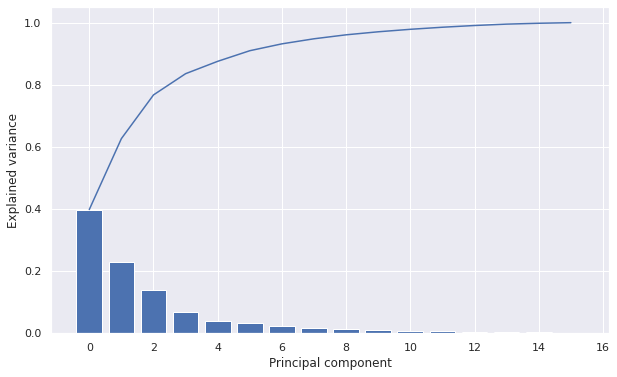

In [122]:
num_components_SeasAndProd = len(pca_SeasAndProd.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components_SeasAndProd), pca_SeasAndProd.explained_variance_ratio_)
plt.plot(np.cumsum(pca_SeasAndProd.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [123]:
pca_SeasAndProd = PCA(n_components=0.80)
pca_SeasAndProd.fit(X_norm_SeasAndProd[:train_end_idx])
X_pca_SeasAndProd = pca_SeasAndProd.transform(X_norm_SeasAndProd)

In [124]:
X_pca_SeasAndProd.shape # from the total 17 Features, there are 4 which explain up to 80% of the variance

(19248, 4)

#### <u>Assemble the new PCA-Dataset</u>:

In [125]:
dataset_norm_SeasAndProd = np.concatenate((X_pca_SeasAndProd, y_norm_SeasAndProd), axis=1)

past_history = 24
future_target = 0

#### <u>Train-Test-Split</u>:

##### <u>Training-Set</u>:

In [126]:
X_train_SeasAndProd, y_train_SeasAndProd = multivariate_data(dataset_norm_SeasAndProd, dataset_norm_SeasAndProd[:, -1],
                                                             0, train_end_idx, past_history, 
                                                             future_target, step=1, single_step=True)

##### <u>Validation-Set</u>:

In [127]:
X_val_SeasAndProd, y_val_SeasAndProd = multivariate_data(dataset_norm_SeasAndProd, dataset_norm_SeasAndProd[:, -1],
                                                         train_end_idx, cv_end_idx, past_history, 
                                                         future_target, step=1, single_step=True)

##### <u>Test-Set</u>:

In [128]:
X_test_SeasAndProd, y_test_SeasAndProd = multivariate_data(dataset_norm_SeasAndProd, dataset_norm_SeasAndProd[:, -1],
                                                           cv_end_idx, test_end_idx, past_history, 
                                                           future_target, step=1, single_step=True)

#### <u>Set some Parameters and use TensorFlow (= Neural Networks)</u>:

In [129]:
batch_size = 32
buffer_size = 1000

Next, we need to **install TensorFlow** on this Data-Science Kit:

- `pip install tensorflow`

In [130]:
train_SeasAndProd = tf.data.Dataset.from_tensor_slices((X_train_SeasAndProd, y_train_SeasAndProd)) # ab hier beginnen wir, TensorFlow zu verwenden
train_SeasAndProd = train_SeasAndProd.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation_SeasAndProd = tf.data.Dataset.from_tensor_slices((X_val_SeasAndProd, y_val_SeasAndProd))
validation_SeasAndProd = validation_SeasAndProd.batch(batch_size).prefetch(1)

In [131]:
# Define some common parameters

input_shape = X_train_SeasAndProd.shape[-2:] # ACHTUNG: musst du dann verändern, wenn du das neue Modell verwendest!
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

##### <u>Last transformation for the (y-) Test-Set</u>:

In [132]:
y_test_SeasAndProd = y_test_SeasAndProd.reshape(-1, 1)
y_test_inv_SeasAndProd = scaler_y_SeasAndProd.inverse_transform(y_test_SeasAndProd)

## Electricity Price Forecasting:

First, let's define a function which will later display how well our model is learning and performing:

In [133]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

### XG-Boost Model:

In [134]:
X_train_xgb_SeasAndProd = X_train_SeasAndProd.reshape(-1, X_train_SeasAndProd.shape[1] * X_train_SeasAndProd.shape[2])
X_val_xgb_SeasAndProd = X_val_SeasAndProd.reshape(-1, X_val_SeasAndProd.shape[1] * X_val_SeasAndProd.shape[2])
X_test_xgb_SeasAndProd = X_test_SeasAndProd.reshape(-1, X_test_SeasAndProd.shape[1] * X_test_SeasAndProd.shape[2])

In [135]:
param_SeasAndProd = {'eta': 0.03, 'max_depth': 180, 'subsample': 1.0, 'colsample_bytree': 0.95, 'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
                     'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain_SeasAndProd = xgb.DMatrix(X_train_xgb_SeasAndProd, y_train_SeasAndProd)
dval_SeasAndProd = xgb.DMatrix(X_val_xgb_SeasAndProd, y_val_SeasAndProd)
dtest_SeasAndProd = xgb.DMatrix(X_test_xgb_SeasAndProd, y_test_SeasAndProd)
eval_list_SeasAndProd = [(dtrain_SeasAndProd, 'train'), (dval_SeasAndProd, 'eval')]

xgb_model_SeasAndProd = xgb.train(param_SeasAndProd, dtrain_SeasAndProd, 180, eval_list_SeasAndProd, early_stopping_rounds=3)

[14:45:05] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:05] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.10466	eval-rmse:0.14475
[1]	train-rmse:0.10164	eval-rmse:0.14079
[2]	train-rmse:0.09871	eval-rmse:0.13686
[3]	train-rmse:0.09587	eval-rmse:0.13311
[4]	train-rmse:0.09312	eval-rmse:0.12955
[5]	train-rmse:0.09046	eval-rmse:0.12603
[6]	train-rmse:0.08787	eval-rmse:0.12263
[7]	train-rmse:0.08537	eval-rmse:0.11939
[8]	train-rmse:0.08295	eval-rmse:0.11625
[9]	train-rmse:0.08059	eval-rmse:0.11313
[10]	train-rmse:0.07831	eval-rmse:0.11010
[11]	train-rmse:0.07611	eval-rmse:0.10719
[12]	train-rmse:0.07397	eval-rmse:0.10442
[13]	train-rmse:0.0

In [136]:
forecast_SeasAndProd = xgb_model_SeasAndProd.predict(dtest_SeasAndProd)
xgb_forecast_SeasAndProd = forecast_SeasAndProd.reshape(-1, 1)

xgb_forecast_inv_SeasAndProd = scaler_y_SeasAndProd.inverse_transform(xgb_forecast_SeasAndProd)

rmse_xgb_SeasAndProd = sqrt(mean_squared_error(y_test_inv_SeasAndProd, xgb_forecast_inv_SeasAndProd))
print('RMSE of day-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb_SeasAndProd, 3))) # The RMSE for this XGBoost-Model should be: 4.173

RMSE of day-ahead electricity price XGBoost forecast: 4.173


#### <u>Zum Vergleich</u>:

- Durchschnittliche RMSE von unserem HPFC-Benchmark: <mark>5.6838</mark>

Das XG-Boost Modell mit PW-Features erzielt eine ca. **36% bessere Performance, als unser HPFC-Benchmark**.

### LSTM Model:

In [143]:
tf.keras.backend.clear_session()

The **next line has a Bug**, and - according to [this link on Github](https://github.com/tensorflow/models/issues/9706)- can be fixed, if you switch to `Python 3.6`.

Another solution may be to run your code on Google-Collab.

In [144]:
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

### CNN

In [145]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [146]:
history = multivariate_cnn.fit(train_SeasAndProd, epochs=120,
                               validation_data=validation_SeasAndProd,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
465/465 [==============================] - 3s 5ms/step - loss: 0.0301 - root_mean_squared_error: 0.1426 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 2/120
465/465 [==============================] - 2s 4ms/step - loss: 6.5641e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 3/120
465/465 [==============================] - 2s 4ms/step - loss: 5.0662e-04 - root_mean_squared_error: 0.0224 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 4/120
465/465 [==============================] - 2s 4ms/step - loss: 3.8320e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 5/120
465/465 [==============================] - 2s 4ms/step - loss: 3.0558e-04 - root_mean_squared_error: 0.0174 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324
Epoch 6/120
465/465 [==============================] - 2s 4ms/step - loss: 2.6378e-04 - root_mean_squared_error: 0.0162

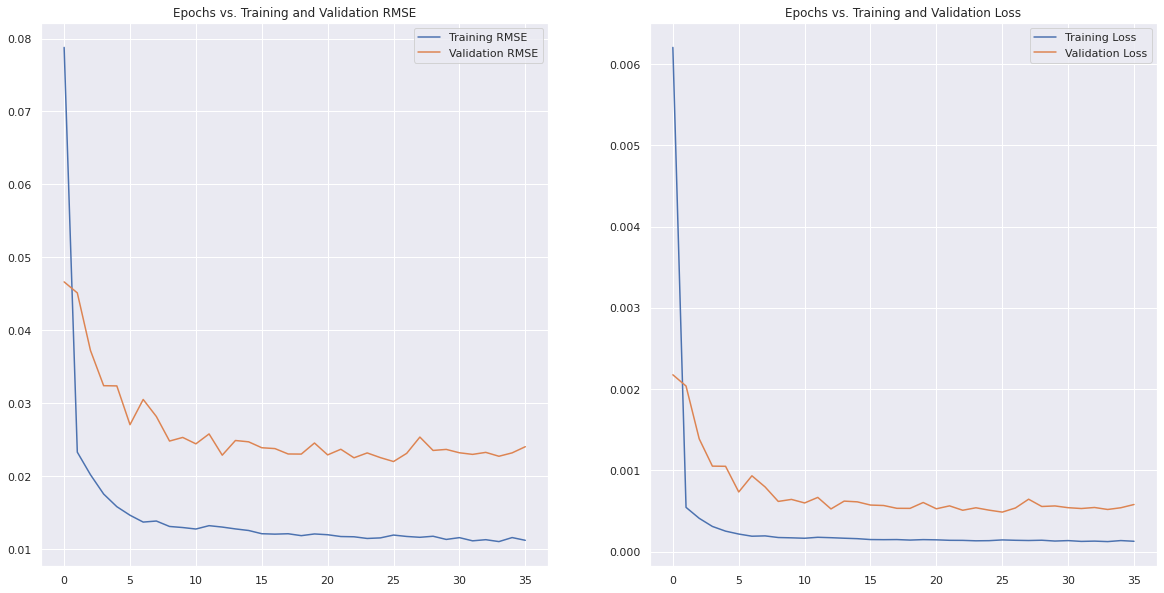

In [147]:
plot_model_rmse_and_loss(history)

In [149]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test_SeasAndProd)
multivariate_cnn_forecast = scaler_y_SeasAndProd.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv_SeasAndProd,
                                        multivariate_cnn_forecast))
print('RMSE of day-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

RMSE of day-ahead electricity price multivariate CNN forecast: 2.809


#### <u>Zum Vergleich</u>:

- Durchschnittliche RMSE von unserem HPFC-Benchmark: <mark>5.6838</mark>

Das **CNN Modell** mit PW-Features erzielt eine ca. **102% bessere Performance, als unser HPFC-Benchmark**.

## Appendix

This is all the code that I used, but did not need in the end.

In [79]:
example = data_energy
example['date'] = example['Date-Time']
example = example.set_index('Date-Time')
example = example.drop(['pricesCH', 'LoadCH', 'LoadD', 'LoadF', 'LoadIT', 'GenCH', 'GenD', 'GenF', 'GenIT', 'RenGenCH', 'RenGenD', 'RenGenF', 'RenGenIT', 
                        'TransFromDach', 'TransToDach', 'TransToIT', 'SeasonAndProduct', 'tInfoDaySin', 'tInfoDayCos', 'tInfoYearSin', 'tInfoYearCos'], axis=1)
example.head()

,date
Date-Time,
2019-01-01 00:00:00+01:00,2019-01-01 00:00:00+01:00
2019-01-01 01:00:00+01:00,2019-01-01 01:00:00+01:00
2019-01-01 02:00:00+01:00,2019-01-01 02:00:00+01:00
2019-01-01 03:00:00+01:00,2019-01-01 03:00:00+01:00
2019-01-01 04:00:00+01:00,2019-01-01 04:00:00+01:00


In [80]:
df_energy = df_energy.drop(['date'], axis=1)

In [81]:
df_energy['date'] = example['date']
df_energy.date = df_energy.date.astype(float)

In [ ]:
df_energy.head()

In [ ]:
# Generate 'hour', 'day_of_week' and 'Quarter' features

# Use the 'Date-Time'-Column to create new columns to extract some 'time-information' (hours, quarters etc...) needed:
df_energy['Hour'] = df_energy.index.apply(lambda x: x.hour) # Werte von 0 [= Stunde 0:00-1:00] bis 23 [= Stunde 23:00-24:00]
df_energy['Quarter'] = df_energy.index.apply(lambda x: x.quarter) # Werte von 1 [Januar bis März] bis 4 [Oktober bis Dezember]
df_energy['day_of_week'] = df_energy.index.apply(lambda x: x.weekday()) # Werte von 0 [= Montag] bis 6 [= Sonntag]